In [6]:
!pip install numpy

Defaulting to user installation because normal site-packages is not writeable


In [1]:
import sys
print(sys.path)

['/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/home/phdo222/.local/lib/python3.10/site-packages', '/usr/local/lib/python3.10/dist-packages', '/usr/lib/python3/dist-packages']


In [2]:
import scanpy as sc
import seaborn as sns

In [1]:
import os
import tempfile

from anndata import AnnData
#import anndata as ad
import muon
import numpy as np
import requests
import io
import scanpy as sc
import scvi
import seaborn as sns
import torch
import pandas as pd
#from biomart import BiomartServer
#from bioservices import BioMart
import rdata
import matplotlib.pyplot as plt
from adjustText import adjust_text
from scipy.stats import beta

/usr/local/lib/python3.10/dist-packages/scvi/__init__.py:31: DeprecationWarning: scvi is deprecated, please uninstall scvi via `pip uninstall scvi` and install the new scvi-tools package at github.com/YosefLab/scvi-tools
  warnings.warn(deprecation_msg, DeprecationWarning)


In [ ]:
pwd

In [ ]:
# Function to get HGNC symbols
def get_hgnc_symbols(gene_ids, chunk_size=200):
    server = "https://www.ensembl.org/biomart/martservice?query="
    
    def create_query(ids):
        ids_str = ",".join(ids)
        query = f"""
        <Query virtualSchemaName = "default" formatter = "TSV" header = "0" uniqueRows = "1" count = "" datasetConfigVersion = "0.6">
            <Dataset name = "hsapiens_gene_ensembl" interface = "default">
                <Filter name = "ensembl_gene_id" value = "{ids_str}"/>
                <Attribute name = "ensembl_transcript_id" />
                <Attribute name = "ensembl_gene_id" />
                <Attribute name = "hgnc_symbol" />
                <Attribute name = "transcript_biotype" />
                <Attribute name = "gene_biotype" />
            </Dataset>
        </Query>
        """
        return query

    all_data = []

    for i in range(0, len(gene_ids), chunk_size):
        chunk = gene_ids[i:i+chunk_size]
        query = create_query(chunk)
        response = requests.get(server + query, headers={"Content-Type": "application/xml"})
        if not response.ok:
            response.raise_for_status()
        data = response.text.strip().split("\n")
        all_data.extend(data)
    
    columns = ['ensembl_transcript_id', 'ensembl_gene_id', 'hgnc_symbol', 'transcript_biotype', 'gene_biotype']
    hgnc = pd.DataFrame([line.split("\t") for line in all_data if line], columns=columns)
    return hgnc

In [ ]:
scvi._settings.seed = 0
print ("Last run with scvi-tools version:", scvi.__version__)

In [2]:
sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme()
torch.set_float32_matmul_precision("high")
save_dir = tempfile.TemporaryDirectory()

# Define the output directory relative to the current working directory
output_dir = './SCVI_python_files'
os.makedirs(output_dir, exist_ok=True)

# You can now use output_dir to save your file s
print(f"Output directory is set to: {output_dir}")

Output directory is set to: ./SCVI_python_files


/usr/local/lib/python3.10/dist-packages/scanpy/_settings.py:488: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  IPython.display.set_matplotlib_formats(*ipython_format)


In [ ]:
## Load gene data
## Define the path to your count matrix file
#PBMC1_gene_path = 'Raw_Data/PBMC1_combined_counts_gene.txt'
#PBMC2_gene_path = 'Raw_Data/PBMC2_combined_counts_gene.txt'

#PBMC1_gene_data = pd.read_csv(PBMC1_gene_path, sep="\t")
#PBMC1_gene_IDs = PBMC1_gene_data[['GENEID']]

#PBMC2_gene_data = pd.read_csv(PBMC2_gene_path, sep="\t")
#PBMC2_gene_IDs = PBMC2_gene_data[['GENEID']]

In [ ]:
##Select out non-bambu genes
#PBMC1_gene_data.to_pickle("PBMC1_gene_data.raw.pkl")
#PBMC1_gene_IDs.to_pickle("PBMC1_gene_IDs.raw.pkl")

#valid_indices_1 = PBMC1_gene_IDs['GENEID'].str.startswith("ENSG")
#valid_gene_ids_1 = PBMC1_gene_IDs['GENEID'][valid_indices_1]
#PBMC1_gene_data = PBMC1_gene_data[valid_indices_1]
#PBMC1_gene_data = PBMC1_gene_data.sort_values(by='GENEID')
#PBMC1_gene_IDs = PBMC1_gene_data[['GENEID']]
#PBMC1_gene_data.to_pickle("PBMC1_gene_data.ENSG.pkl")
#PBMC1_gene_IDs.to_pickle("PBMC1_gene_IDs.ENSG.pkl")

#PBMC2_gene_data.to_pickle("PBMC2_gene_data.raw.pkl")
#PBMC2_gene_IDs.to_pickle("PBMC2_gene_IDs.raw.pkl")

#valid_indices_2 = PBMC2_gene_IDs['GENEID'].str.startswith("ENSG")
#valid_gene_ids_2 = PBMC2_gene_IDs['GENEID'][valid_indices_2]
#PBMC2_gene_data = PBMC2_gene_data[valid_indices_2]
#PBMC2_gene_data = PBMC2_gene_data.sort_values(by='GENEID')
#PBMC2_gene_IDs = PBMC2_gene_data[['GENEID']]
#PBMC2_gene_data.to_pickle("PBMC2_gene_data.ENSG.pkl")
#PBMC2_gene_IDs.to_pickle("PBMC2_gene_IDs.ENSG.pkl")

In [ ]:
PBMC1_gene_data.head()

In [ ]:
## Load isoform data
## Define the path to your count matrix file
PBMC1_iso_path = 'Raw_Data/PBMC1_combined_counts_transcript.txt'
PBMC2_iso_path = 'Raw_Data/PBMC2_combined_counts_transcript.txt'

PBMC1_iso_data = pd.read_csv(PBMC1_iso_path, sep="\t")
PBMC1_iso_IDs = PBMC1_iso_data[['TXNAME', 'GENEID']]

PBMC2_iso_data = pd.read_csv(PBMC2_iso_path, sep="\t")
PBMC2_iso_IDs = PBMC2_iso_data[['TXNAME', 'GENEID']]

In [ ]:
# Save the raw data first for backup
PBMC1_isoform_data.to_pickle("PBMC1_isoform_data.raw.pkl")
PBMC1_isoform_IDs.to_pickle("PBMC1_isoform_IDs.raw.pkl")
PBMC2_isoform_data.to_pickle("PBMC2_isoform_data.raw.pkl")
PBMC2_isoform_IDs.to_pickle("PBMC2_isoform_IDs.raw.pkl")

In [ ]:
# Subset the isoform data with only Ensembl IDs starting with "ENST"
iso_valid_indices_1 = PBMC1_isoform_IDs['TXNAME'].str.startswith("ENST")
iso_valid_gene_ids_1 = PBMC1_isoform_IDs['GENEID'][iso_valid_indices_1]
iso_valid_indices_2 = PBMC2_isoform_IDs['TXNAME'].str.startswith("ENST")
iso_valid_gene_ids_2 = PBMC2_isoform_IDs['GENEID'][iso_valid_indices_2]

# Subset the isoform data based on valid indices
PBMC1_isoform_data_ENST = PBMC1_isoform_data[iso_valid_indices_1]
PBMC1_isoform_data_ENST = PBMC1_isoform_data[iso_valid_indices_1]

# Sort the subsetted isoform data by "TXNAME"
PBMC1_isoform_data_ENST = PBMC1_isoform_data_ENST.sort_values(by='TXNAME')

# Select only "TXNAME" and "GENEID" columns
PBMC1_isoform_IDs_ENST = PBMC1_isoform_data_ENST[['TXNAME', 'GENEID']]

# Save the subsetted and sorted data
PBMC1_isoform_data_ENST.to_pickle("PBMC1_isoform_data.ENST.pkl")
PBMC1_isoform_IDs_ENST.to_pickle("PBMC1_isoform_IDs.ENST.pkl")

In [4]:
# Define the paths to your pickled data
PBMC1_gene_path = os.path.join(output_dir, 'PBMC1_gene_data.ENSG.pkl')
PBMC2_gene_path = os.path.join(output_dir, 'PBMC2_gene_data.ENSG.pkl')
PBMC1_gene_IDs_path = os.path.join(output_dir, 'PBMC1_gene_IDs.ENSG.pkl')
PBMC2_gene_IDs_path = os.path.join(output_dir, 'PBMC2_gene_IDs.ENSG.pkl')
PBMC1_iso_path = os.path.join(output_dir, 'PBMC1_iso_data.ENST.pkl')
PBMC2_iso_path = os.path.join(output_dir, 'PBMC2_iso_data.ENST.pkl')
PBMC1_iso_IDs_path = os.path.join(output_dir, 'PBMC1_iso_IDs.ENST.pkl')
PBMC2_iso_IDs_path = os.path.join(output_dir, 'PBMC2_iso_IDs.ENST.pkl')

# Load gene data from pickle files
PBMC1_gene_data = pd.read_pickle(PBMC1_gene_path)
PBMC2_gene_data = pd.read_pickle(PBMC2_gene_path)
PBMC1_gene_IDs = pd.read_pickle(PBMC1_gene_IDs_path)
PBMC2_gene_IDs = pd.read_pickle(PBMC2_gene_IDs_path)

PBMC1_iso_data = pd.read_pickle(PBMC1_iso_path)
PBMC2_iso_data = pd.read_pickle(PBMC2_iso_path)
PBMC1_iso_IDs = pd.read_pickle(PBMC1_iso_IDs_path)
PBMC2_iso_IDs = pd.read_pickle(PBMC2_iso_IDs_path)

In [5]:
print(PBMC1_gene_data.shape)
print(PBMC2_gene_data.shape)
print(PBMC1_gene_IDs.shape)
print(PBMC2_gene_IDs.shape)

(61860, 17580)
(61860, 23895)
(61860, 1)
(61860, 1)


In [6]:
print(PBMC1_iso_data.shape)
print(PBMC2_iso_data.shape)
print(PBMC1_iso_IDs.shape)
print(PBMC2_iso_IDs.shape)

(251121, 17581)
(251121, 23896)
(251121, 2)
(251121, 2)


In [7]:
# Ensure that PBMC1_gene_IDs and PBMC2_gene_IDs are DataFrames
if isinstance(PBMC1_gene_IDs, pd.DataFrame) and isinstance(PBMC2_gene_IDs, pd.DataFrame):
    # Align indices of the Series before comparison
    PBMC1_gene_IDs_sorted = PBMC1_gene_IDs.sort_values(by='GENEID').reset_index(drop=True)
    PBMC2_gene_IDs_sorted = PBMC2_gene_IDs.sort_values(by='GENEID').reset_index(drop=True)

    identical_genes = (PBMC1_gene_IDs_sorted['GENEID'] == PBMC2_gene_IDs_sorted['GENEID']).all()
    print(f"Gene IDs identical: {identical_genes}")
else:
    print("PBMC1_gene_IDs or PBMC2_gene_IDs is not a DataFrame")

Gene IDs identical: True


In [8]:
# Ensure that PBMC1_gene_IDs and PBMC2_gene_IDs are DataFrames
if isinstance(PBMC1_iso_IDs, pd.DataFrame) and isinstance(PBMC2_iso_IDs, pd.DataFrame):
    # Align indices of the Series before comparison
    PBMC1_iso_IDs_sorted = PBMC1_iso_IDs.sort_values(by='GENEID').reset_index(drop=True)
    PBMC2_iso_IDs_sorted = PBMC2_iso_IDs.sort_values(by='GENEID').reset_index(drop=True)

    identical_genes = (PBMC1_iso_IDs_sorted['GENEID'] == PBMC2_iso_IDs_sorted['GENEID']).all()
    print(f"Gene IDs identical: {identical_genes}")
else:
    print("PBMC1_iso_IDs or PBMC2_iso_IDs is not a DataFrame")

Gene IDs identical: True


In [8]:
import os

output_dir = './SCVI_python_files'  # Replace with the actual directory path
files = os.listdir(output_dir)
print(files)

['Concatenated_Data.h5ad', 'PBMC1_gene_IDs.ENSG.pkl', 'markers_res_AUTOZI_0.4.csv', 'PBMC2_gene_IDs.ENSG.pkl', 'gene_PBMC_IDs.pkl', 'hgnc.PBMC.isoform.RData', 'PBMC1_iso_data.ENST.pkl', 'isoform_PBMC_IDs.pkl', 'hgnc.PBMC.RData', 'markers_res_0.8.csv', 'PBMC2_gene_filtered.h5ad', 'PBMC2_isoform_data.raw.pkl', 'PBMC1_gene.h5ad', 'PBMC1_isoform_IDs.raw.pkl', '.ipynb_checkpoints', 'PBMC2_gene.h5ad', 'isoform.PBMC.IDs.RData', 'hgnc.iso.PBMC.pkl', 'hgnc.PBMC.pkl', 'PBMC1_gene_filtered.h5ad', 'model.pt', 'Models', 'PBMC1_gene_IDs.raw.pkl', 'PBMC2_gene_data.ENSG.pkl', 'markers_res_AUTOZI_0.8.csv', 'markers_res_0.4.csv', 'PBMC1_isoform_data.raw.pkl', 'mdata_object_with_latent.h5mu', 'PBMC2_iso_data.ENST.pkl', 'gene_IDs.ENSG.pkl', 'PBMC1_gene_data.raw.pkl', 'PBMC1_gene_data.ENSG.pkl', 'markers_res_AUTOZI_1.0.csv', 'PBMC1_iso_IDs.ENST.pkl', 'PBMC2_gene_IDs.raw.pkl', 'markers_res_1.0.csv', 'PBMC2_gene_data.raw.pkl', 'PBMC2_isoform_IDs.raw.pkl', 'PBMC2_iso_IDs.ENST.pkl']


In [9]:
## Get HGNC symbols
#gene_ids = PBMC1_gene_IDs['GENEID'].unique()
#hgnc = get_hgnc_symbols(gene_ids)

## Save the HGNC DataFrame to a .pkl file
#hgnc.to_pickle("hgnc.PBMC.pkl")



## Load HGNC symbols
#hgnc_path= 'hgnc.PBMC.RData'
#parsed = rdata.parser.parse_file(hgnc_path)
#hgnc_convert = rdata.conversion.convert(parsed)

## Since the `convert` function returns a dictionary, we extract the DataFrame
#hgnc = hgnc_convert[next(iter(hgnc_convert))]

## Save the HGNC DataFrame to a .pkl file
#hgnc.to_pickle("hgnc.PBMC.pkl")

## Load in hgnc data
hgnc_path = os.path.join(output_dir, 'hgnc.PBMC.pkl')
hgnc_gene = pd.read_pickle(hgnc_path)

In [8]:

## Load HGNC symbols
#hgnc_iso_path= os.path.join(output_dir, 'hgnc.PBMC.isoform.RData')
#parsed = rdata.parser.parse_file(hgnc_iso_path)
#hgnc_convert = rdata.conversion.convert(parsed)

## Since the `convert` function returns a dictionary, we extract the DataFrame
#hgnc = hgnc_convert[next(iter(hgnc_convert))]

## Save the HGNC DataFrame to a .pkl file
#hgnc.to_pickle("hgnc.iso.PBMC.pkl")

## Load in hgnc data
hgnc_iso_path = os.path.join(output_dir, 'hgnc.iso.PBMC.pkl')
hgnc_iso = pd.read_pickle(hgnc_iso_path)

In [10]:
# Extract the columns 'hgnc_symbol' and 'ensembl_gene_id' into a new DataFrame
hgnc_gene = hgnc_gene[['hgnc_symbol', 'ensembl_gene_id']].drop_duplicates()
hgnc_gene.head()

,hgnc_symbol,ensembl_gene_id
0,TSPAN6,ENSG00000000003
4,TNMD,ENSG00000000005
6,DPM1,ENSG00000000419
22,SCYL3,ENSG00000000457
27,FIRRM,ENSG00000000460


In [11]:
hgnc_gene.shape

(61668, 2)

In [12]:
# Merge gene symbols with gene IDs
gene_IDs = pd.merge(PBMC1_gene_IDs[['GENEID']], hgnc_gene[['ensembl_gene_id', 'hgnc_symbol']], left_on='GENEID', right_on='ensembl_gene_id', how='left')

In [13]:
gene_IDs.shape

(61863, 3)

In [14]:
# Convert NaN values to empty strings before joining
gene_IDs['hgnc_symbol'] = gene_IDs['hgnc_symbol'].fillna('')

## Group by 'GENEID' and aggregate the data to handle duplicates
gene_IDs= gene_IDs.groupby('GENEID').agg({
    'hgnc_symbol': lambda x: ';'.join(set(x.astype(str))),
    'ensembl_gene_id': 'first'  # Or use any other aggregation logic as needed
}).reset_index()

In [15]:
gene_IDs.shape

(61860, 3)

In [16]:
## Step 1: Left join PBMC1_isoform_IDs with hgnc on "GENEID" and "TXNAME"
#isoform_IDs = pd.merge(PBMC1_iso_IDs, hgnc_iso, how='left', left_on=['GENEID', 'TXNAME'], right_on=['ensembl_gene_id', 'ensembl_transcript_id'])

## Step 2: Convert the relevant columns to string before performing the fillna and concatenation
#isoform_IDs['hgnc_symbol'] = isoform_IDs['hgnc_symbol'].astype(str)
#isoform_IDs['GENEID'] = isoform_IDs['GENEID'].astype(str)
#isoform_IDs['TXNAME'] = isoform_IDs['TXNAME'].astype(str)

## Step 3: Combine "hgnc_symbol", "GENEID", and "TXNAME" into a new column "combined_IDs"
## Convert all values to strings and replace NaN with an empty string
#isoform_IDs['combined_IDs'] = isoform_IDs[['hgnc_symbol', 'GENEID', 'TXNAME']].fillna('').agg(':'.join, axis=1)

## Step 4: Convert all string (character) columns to categorical (similar to R's factor)
#isoform_IDs = isoform_IDs.apply(lambda col: col.astype('category') if col.dtype == 'object' else col)
## Group by 'TXNAME' and aggregate the data to handle duplicates
#isoform_IDs = isoform_IDs.groupby('TXNAME').agg({
#    'hgnc_symbol': lambda x: ';'.join(set(x.astype(str))),  # Combine unique hgnc_symbol entries
#    'GENEID': 'first',  # Use the first GENEID or apply a different aggregation logic if needed
#    'ensembl_transcript_id': 'first',  # You can also aggregate or handle other columns similarly
#    'ensembl_gene_id': 'first'  # Handle duplicates for ensembl_gene_id by taking the first value
#}).reset_index()

## Step 5: Save the DataFrame to a pickle file
#isoform_IDs.to_pickle('isoform_PBMC_IDs.pkl')

## Load in isoform IDs
iso_path = os.path.join(output_dir, 'isoform_PBMC_IDs.pkl')
isoform_IDs = pd.read_pickle(iso_path)

# Print the first few rows of the resulting DataFrame to verify
print(isoform_IDs.head())

            TXNAME hgnc_symbol           GENEID ensembl_transcript_id  \
0  ENST00000000233        ARF5  ENSG00000004059       ENST00000000233   
1  ENST00000000412        M6PR  ENSG00000003056       ENST00000000412   
2  ENST00000000442       ESRRA  ENSG00000173153       ENST00000000442   
3  ENST00000001008       FKBP4  ENSG00000004478       ENST00000001008   
4  ENST00000001146     CYP26B1  ENSG00000003137       ENST00000001146   

   ensembl_gene_id  
0  ENSG00000004059  
1  ENSG00000003056  
2  ENSG00000173153  
3  ENSG00000004478  
4  ENSG00000003137  


In [17]:
# Sort each dataframe by the GENEID column
sorted_PBMC1_gene_data = PBMC1_gene_data.sort_values(by='GENEID').reset_index(drop=True)
sorted_PBMC2_gene_data = PBMC2_gene_data.sort_values(by='GENEID').reset_index(drop=True)
sorted_gene_IDs = gene_IDs.sort_values(by='GENEID').reset_index(drop=True)

# Sort each dataframe by the GENEID column
sorted_PBMC1_iso_data = PBMC1_iso_data.sort_values(by='GENEID').reset_index(drop=True)
sorted_PBMC2_iso_data = PBMC2_iso_data.sort_values(by='GENEID').reset_index(drop=True)
sorted_iso_IDs = isoform_IDs.sort_values(by='GENEID').reset_index(drop=True)

In [18]:
# Check if the GENEID columns are identical
pbmc1_gene_ids_identical = sorted_PBMC1_gene_data['GENEID'].equals(sorted_gene_IDs['GENEID'])
pbmc2_gene_ids_identical = sorted_PBMC2_gene_data['GENEID'].equals(sorted_gene_IDs['GENEID'])
pbmc1_iso_ids_identical = sorted_PBMC1_iso_data['GENEID'].equals(sorted_iso_IDs['GENEID'])
pbmc2_iso_ids_identical = sorted_PBMC2_iso_data['GENEID'].equals(sorted_iso_IDs['GENEID'])

print("Are the GENEID columns of PBMC1_gene_data and gene_IDs identical?", pbmc1_gene_ids_identical)
print("Are the GENEID columns of PBMC2_gene_data and gene_IDs identical?", pbmc2_gene_ids_identical)
print("Are the GENEID columns of PBMC1_gene_data and isoform_IDs identical?", pbmc1_iso_ids_identical)
print("Are the GENEID columns of PBMC2_gene_data and isoform_IDs identical?", pbmc2_iso_ids_identical)

# Print the first few values for manual verification
print("First few values of sorted_PBMC1_gene_data:")
print(sorted_PBMC1_gene_data.head())

print("First few values of sorted_PBMC2_gene_data:")
print(sorted_PBMC2_gene_data.head())

print("First few values of sorted_gene_IDs:")
print(sorted_gene_IDs.head())

# Print the first few values for manual verification
print("First few values of sorted_PBMC1_iso_data:")
print(sorted_PBMC1_iso_data.head())

print("First few values of sorted_PBMC2_iso_data:")
print(sorted_PBMC2_iso_data.head())

print("First few values of sorted_iso_IDs:")
print(sorted_iso_IDs.head())

Are the GENEID columns of PBMC1_gene_data and gene_IDs identical? True
Are the GENEID columns of PBMC2_gene_data and gene_IDs identical? True
Are the GENEID columns of PBMC1_gene_data and isoform_IDs identical? True
Are the GENEID columns of PBMC2_gene_data and isoform_IDs identical? True
First few values of sorted_PBMC1_gene_data:
            GENEID  PBMC1_test_AGGCATAACAGTACGG_filtered_mapq_10  \
0  ENSG00000000003                                           0.0   
1  ENSG00000000005                                           0.0   
2  ENSG00000000419                                           0.0   
3  ENSG00000000457                                           0.0   
4  ENSG00000000460                                           0.0   

   PBMC1_test_CATGAATGAATTCAAG_filtered_mapq_10  \
0                                           0.0   
1                                           0.0   
2                                           0.0   
3                                           0.0   
4 

In [19]:
PBMC1_gene_data = sorted_PBMC1_gene_data
PBMC2_gene_data = sorted_PBMC2_gene_data
PBMC1_iso_data = sorted_PBMC1_iso_data
PBMC2_iso_data = sorted_PBMC2_iso_data

In [23]:
print(dir())

['AnnData', 'In', 'Out', 'PBMC1_iso_data', 'PBMC2_iso_data', '_', '_16', '__', '___', '__builtin__', '__builtins__', '__doc__', '__loader__', '__name__', '__package__', '__session__', '__spec__', '_dh', '_i', '_i1', '_i10', '_i11', '_i12', '_i13', '_i14', '_i15', '_i16', '_i17', '_i18', '_i19', '_i2', '_i20', '_i21', '_i22', '_i23', '_i3', '_i4', '_i5', '_i6', '_i7', '_i8', '_i9', '_ih', '_ii', '_iii', '_oh', 'adjust_text', 'beta', 'exit', 'files', 'get_ipython', 'io', 'isoform_IDs', 'muon', 'np', 'open', 'os', 'output_dir', 'pd', 'plt', 'quit', 'rdata', 'requests', 'save_dir', 'sc', 'scvi', 'sns', 'sorted_iso_IDs', 'tempfile', 'torch', 'var']


In [22]:
for var in ['PBMC1_iso_IDs_path', 'PBMC1_iso_IDs_sorted', 'PBMC1_iso_path', 'PBMC1_iso_IDs', 
            'PBMC2_iso_IDs_path', 'PBMC2_iso_IDs_sorted', 'PBMC2_iso_path', 'PBMC2_iso_IDs', 
            'hgnc_iso', 'hgnc_iso_path', 'identical_genes', 'pbmc1_iso_ids_identical', 
            'pbmc2_iso_ids_identical', 'sorted_PBMC1_iso_data', 'sorted_PBMC2_iso_data']:
    if var in globals():
        del globals()[var]

In [20]:
# Create combined IDs
gene_IDs['combined_IDs'] = sorted_gene_IDs['hgnc_symbol'].astype(str) + ":" + sorted_gene_IDs['GENEID'].astype(str)
# Align the index correctly
gene_IDs = gene_IDs['combined_IDs']

In [21]:
gene_IDs.shape

(61860,)

In [22]:
# Ensure the gene data matrices have the same genes in the same order
PBMC1_gene_data = PBMC1_gene_data.set_index(gene_IDs)
PBMC2_gene_data = PBMC2_gene_data.set_index(gene_IDs)

In [23]:
PBMC1_gene_data.head()

,GENEID,PBMC1_test_AGGCATAACAGTACGG_filtered_mapq_10,PBMC1_test_CATGAATGAATTCAAG_filtered_mapq_10,PBMC1_test_CCGAAAGTATTGCCTG_filtered_mapq_10,PBMC1_test_CAACATCCCAATCCTA_filtered_mapq_10,PBMC1_test_AGATAAAAATCGAACT_filtered_mapq_10,PBMC1_test_AGGACAACACGTATGT_filtered_mapq_10,PBMC1_test_AGGGAATTATCAACCA_filtered_mapq_10,PBMC1_test_ATGGCACGAAGACCTC_filtered_mapq_10,PBMC1_test_AAAGATGAAAGGCCGA_filtered_mapq_10,...,PBMC1_test_CAACATCAACCGATCC_filtered_mapq_10,PBMC1_test_ACCGATCAAACCATAA_filtered_mapq_10,PBMC1_test_ACCTCACCAGGTATTG_filtered_mapq_10,PBMC1_test_CACCCATCAATCCCTG_filtered_mapq_10,PBMC1_test_AATACATAAGTGAACG_filtered_mapq_10,PBMC1_test_AGGTCCACAGACACGG_filtered_mapq_10,PBMC1_test_ACTAACCACCGCAAGG_filtered_mapq_10,PBMC1_test_ATGTATAAAAGCACAA_filtered_mapq_10,PBMC1_test_ATTGATATCCAGATCA_filtered_mapq_10,PBMC1_test_CAAGCCAAAGCTCATT_filtered_mapq_10
combined_IDs,,,,,,,,,,,,,,,,,,,,,
TSPAN6:ENSG00000000003,ENSG00000000003,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TNMD:ENSG00000000005,ENSG00000000005,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
DPM1:ENSG00000000419,ENSG00000000419,0.0,0.0,0.0,1.99999,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SCYL3:ENSG00000000457,ENSG00000000457,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
FIRRM:ENSG00000000460,ENSG00000000460,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
# Remove the 'GENEID' column
PBMC1_gene_data = PBMC1_gene_data.drop(columns=['GENEID'])
PBMC2_gene_data = PBMC2_gene_data.drop(columns=['GENEID'])

In [27]:
PBMC1_gene_data.head()

,PBMC1_test_AGGCATAACAGTACGG_filtered_mapq_10,PBMC1_test_CATGAATGAATTCAAG_filtered_mapq_10,PBMC1_test_CCGAAAGTATTGCCTG_filtered_mapq_10,PBMC1_test_CAACATCCCAATCCTA_filtered_mapq_10,PBMC1_test_AGATAAAAATCGAACT_filtered_mapq_10,PBMC1_test_AGGACAACACGTATGT_filtered_mapq_10,PBMC1_test_AGGGAATTATCAACCA_filtered_mapq_10,PBMC1_test_ATGGCACGAAGACCTC_filtered_mapq_10,PBMC1_test_AAAGATGAAAGGCCGA_filtered_mapq_10,PBMC1_test_CAAGATTGAGGTAAAT_filtered_mapq_10,...,PBMC1_test_CAACATCAACCGATCC_filtered_mapq_10,PBMC1_test_ACCGATCAAACCATAA_filtered_mapq_10,PBMC1_test_ACCTCACCAGGTATTG_filtered_mapq_10,PBMC1_test_CACCCATCAATCCCTG_filtered_mapq_10,PBMC1_test_AATACATAAGTGAACG_filtered_mapq_10,PBMC1_test_AGGTCCACAGACACGG_filtered_mapq_10,PBMC1_test_ACTAACCACCGCAAGG_filtered_mapq_10,PBMC1_test_ATGTATAAAAGCACAA_filtered_mapq_10,PBMC1_test_ATTGATATCCAGATCA_filtered_mapq_10,PBMC1_test_CAAGCCAAAGCTCATT_filtered_mapq_10
combined_IDs,,,,,,,,,,,,,,,,,,,,,
TSPAN6:ENSG00000000003,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TNMD:ENSG00000000005,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
DPM1:ENSG00000000419,0.0,0.0,0.0,1.99999,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SCYL3:ENSG00000000457,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
FIRRM:ENSG00000000460,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
#Save gene_IDs to file
#gene_IDs.to_pickle("gene_IDs.ENSG.pkl")

#load gene IDs
gene_ID_path = os.path.join(output_dir, 'gene_IDs.ENSG.pkl')
gene_IDs = pd.read_pickle(gene_ID_path)

In [28]:
# Create combined IDs
isoform_IDs['combined_IDs'] = sorted_iso_IDs['hgnc_symbol'].astype(str) + ":" + sorted_iso_IDs['GENEID'].astype(str) + ":" + sorted_iso_IDs['TXNAME'].astype(str)
# Align the index correctly
isoform_IDs = isoform_IDs['combined_IDs']

In [29]:
isoform_IDs.shape

(251121,)

In [30]:
# Ensure the gene data matrices have the same genes in the same order
PBMC1_iso_data = PBMC1_iso_data.set_index(isoform_IDs)
PBMC2_iso_data = PBMC2_iso_data.set_index(isoform_IDs)

In [31]:
PBMC1_iso_data.head()

,TXNAME,GENEID,PBMC1_test_AGCGAGCTAGAGAGTT_filtered_mapq_10,PBMC1_test_CAGTAAGAAGGCATCG_filtered_mapq_10,PBMC1_test_CCATAGCTCCTGATAA_filtered_mapq_10,PBMC1_test_CCCGACCTACAGCCCG_filtered_mapq_10,PBMC1_test_AAGTCACCAAATAAGT_filtered_mapq_10,PBMC1_test_ATCAACGCCAAGAGAC_filtered_mapq_10,PBMC1_test_ACGTAAGTAATTCACT_filtered_mapq_10,PBMC1_test_ACCGCCTAACGAAGCA_filtered_mapq_10,...,PBMC1_test_AGTTCCCCAGATCCGT_filtered_mapq_10,PBMC1_test_AACCCCTCCATGAACC_filtered_mapq_10,PBMC1_test_CATAAAGTAAGCATAT_filtered_mapq_10,PBMC1_test_AGAAATGGCCTTCCAC_filtered_mapq_10,PBMC1_test_ATGGATCTCCAAAATC_filtered_mapq_10,PBMC1_test_AATGAGGCAGGCCACT_filtered_mapq_10,PBMC1_test_ATTTACGAAGCACCAG_filtered_mapq_10,PBMC1_test_ATTGACCGACTTAAGA_filtered_mapq_10,PBMC1_test_AAACAGAAAAGAACTG_filtered_mapq_10,PBMC1_test_AACCCCTGAGTTAGGG_filtered_mapq_10
combined_IDs,,,,,,,,,,,,,,,,,,,,,
nan:ENSG00000000003:ENST00000614008,ENST00000614008,ENSG00000000003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TSPAN6:ENSG00000000003:ENST00000496771,ENST00000496771,ENSG00000000003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TSPAN6:ENSG00000000003:ENST00000612152,ENST00000612152,ENSG00000000003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TSPAN6:ENSG00000000003:ENST00000373020,ENST00000373020,ENSG00000000003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TSPAN6:ENSG00000000003:ENST00000494424,ENST00000494424,ENSG00000000003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
# Remove the 'GENEID' and 'TXNAME' columns
PBMC1_iso_data = PBMC1_iso_data.drop(columns=['GENEID'])
PBMC2_iso_data = PBMC2_iso_data.drop(columns=['GENEID'])
PBMC1_iso_data = PBMC1_iso_data.drop(columns=['TXNAME'])
PBMC2_iso_data = PBMC2_iso_data.drop(columns=['TXNAME'])

In [33]:
PBMC1_iso_data.head()

,PBMC1_test_AGCGAGCTAGAGAGTT_filtered_mapq_10,PBMC1_test_CAGTAAGAAGGCATCG_filtered_mapq_10,PBMC1_test_CCATAGCTCCTGATAA_filtered_mapq_10,PBMC1_test_CCCGACCTACAGCCCG_filtered_mapq_10,PBMC1_test_AAGTCACCAAATAAGT_filtered_mapq_10,PBMC1_test_ATCAACGCCAAGAGAC_filtered_mapq_10,PBMC1_test_ACGTAAGTAATTCACT_filtered_mapq_10,PBMC1_test_ACCGCCTAACGAAGCA_filtered_mapq_10,PBMC1_test_AGTGCACACAAGATTG_filtered_mapq_10,PBMC1_test_AGAAACTTATCTCCTG_filtered_mapq_10,...,PBMC1_test_AGTTCCCCAGATCCGT_filtered_mapq_10,PBMC1_test_AACCCCTCCATGAACC_filtered_mapq_10,PBMC1_test_CATAAAGTAAGCATAT_filtered_mapq_10,PBMC1_test_AGAAATGGCCTTCCAC_filtered_mapq_10,PBMC1_test_ATGGATCTCCAAAATC_filtered_mapq_10,PBMC1_test_AATGAGGCAGGCCACT_filtered_mapq_10,PBMC1_test_ATTTACGAAGCACCAG_filtered_mapq_10,PBMC1_test_ATTGACCGACTTAAGA_filtered_mapq_10,PBMC1_test_AAACAGAAAAGAACTG_filtered_mapq_10,PBMC1_test_AACCCCTGAGTTAGGG_filtered_mapq_10
combined_IDs,,,,,,,,,,,,,,,,,,,,,
nan:ENSG00000000003:ENST00000614008,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TSPAN6:ENSG00000000003:ENST00000496771,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TSPAN6:ENSG00000000003:ENST00000612152,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TSPAN6:ENSG00000000003:ENST00000373020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TSPAN6:ENSG00000000003:ENST00000494424,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
print("Shape of PBMC1_gene_data:", PBMC1_gene_data.shape)
print("Shape of PBMC2_gene_data:", PBMC2_gene_data.shape)
print("Shape of PBMC1_gene_IDs:", PBMC1_gene_IDs.shape)
print("Shape of PBMC2_gene_IDs:", PBMC2_gene_IDs.shape)
print("Length of gene_IDs:", len(gene_IDs))

print("Shape of PBMC1_iso_data:", PBMC1_iso_data.shape)
print("Shape of PBMC2_iso_data:", PBMC2_iso_data.shape)
print("Shape of PBMC1_iso_IDs:", PBMC1_iso_IDs.shape)
print("Shape of PBMC2_iso_IDs:", PBMC2_iso_IDs.shape)
print("Length of isoform_IDs:", len(isoform_IDs))

Shape of PBMC1_gene_data: (17579, 61860)
Shape of PBMC2_gene_data: (23894, 61860)
Shape of PBMC1_gene_IDs: (61860, 1)
Shape of PBMC2_gene_IDs: (61860, 1)
Length of gene_IDs: 61860
Shape of PBMC1_iso_data: (17579, 251121)
Shape of PBMC2_iso_data: (23894, 251121)
Shape of PBMC1_iso_IDs: (251121, 2)
Shape of PBMC2_iso_IDs: (251121, 2)
Length of isoform_IDs: 251121


In [35]:
# Ensure the data is in the correct orientation: genes as columns, cells as rows
if PBMC1_gene_data.shape[0] > PBMC1_gene_data.shape[1]:
    PBMC1_gene_data = PBMC1_gene_data.T

if PBMC2_gene_data.shape[0] > PBMC2_gene_data.shape[1]:
    PBMC2_gene_data = PBMC2_gene_data.T

In [36]:
# Ensure the data is in the correct orientation: genes as columns, cells as rows
if PBMC1_iso_data.shape[0] > PBMC1_iso_data.shape[1]:
    PBMC1_iso_data = PBMC1_iso_data.T

if PBMC2_iso_data.shape[0] > PBMC2_iso_data.shape[1]:
    PBMC2_iso_data = PBMC2_iso_data.T

In [38]:
print("Shape of PBMC1_gene_data:", PBMC1_gene_data.shape)
print("Shape of PBMC2_gene_data:", PBMC2_gene_data.shape)
print("Shape of PBMC1_gene_IDs:", PBMC1_gene_IDs.shape)
print("Shape of PBMC2_gene_IDs:", PBMC2_gene_IDs.shape)
print("Length of gene_IDs:", len(gene_IDs))

print("Shape of PBMC1_iso_data:", PBMC1_iso_data.shape)
print("Shape of PBMC2_iso_data:", PBMC2_iso_data.shape)
print("Shape of PBMC1_iso_IDs:", PBMC1_iso_IDs.shape)
print("Shape of PBMC2_iso_IDs:", PBMC2_iso_IDs.shape)
print("Length of isoform_IDs:", len(isoform_IDs))

Shape of PBMC1_gene_data: (17579, 61860)
Shape of PBMC2_gene_data: (23894, 61860)
Shape of PBMC1_gene_IDs: (61860, 1)
Shape of PBMC2_gene_IDs: (61860, 1)
Length of gene_IDs: 61860
Shape of PBMC1_iso_data: (17579, 251121)
Shape of PBMC2_iso_data: (23894, 251121)
Shape of PBMC1_iso_IDs: (251121, 2)
Shape of PBMC2_iso_IDs: (251121, 2)
Length of isoform_IDs: 251121


In [49]:
PBMC1_gene_data.head()

combined_IDs,TSPAN6:ENSG00000000003,TNMD:ENSG00000000005,DPM1:ENSG00000000419,SCYL3:ENSG00000000457,FIRRM:ENSG00000000460,FGR:ENSG00000000938,CFH:ENSG00000000971,FUCA2:ENSG00000001036,GCLC:ENSG00000001084,NFYA:ENSG00000001167,...,:ENSG00000290126,:ENSG00000290127,:ENSG00000290146,GUCA1ANB-GUCA1A:ENSG00000290147,:ENSG00000290149,:ENSG00000290162,:ENSG00000290163,:ENSG00000290164,:ENSG00000290165,:ENSG00000290166
PBMC1_test_AGGCATAACAGTACGG_filtered_mapq_10,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PBMC1_test_CATGAATGAATTCAAG_filtered_mapq_10,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PBMC1_test_CCGAAAGTATTGCCTG_filtered_mapq_10,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PBMC1_test_CAACATCCCAATCCTA_filtered_mapq_10,0.0,0.0,1.99999,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PBMC1_test_AGATAAAAATCGAACT_filtered_mapq_10,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [50]:
PBMC1_iso_data.head()

combined_IDs,nan:ENSG00000000003:ENST00000614008,TSPAN6:ENSG00000000003:ENST00000496771,TSPAN6:ENSG00000000003:ENST00000612152,TSPAN6:ENSG00000000003:ENST00000373020,TSPAN6:ENSG00000000003:ENST00000494424,TNMD:ENSG00000000005:ENST00000373031,TNMD:ENSG00000000005:ENST00000485971,DPM1:ENSG00000000419:ENST00000371582,DPM1:ENSG00000000419:ENST00000371584,DPM1:ENSG00000000419:ENST00000371588,...,GUCA1ANB-GUCA1A:ENSG00000290147:ENST00000703267,GUCA1ANB-GUCA1A:ENSG00000290147:ENST00000654459,GUCA1ANB-GUCA1A:ENSG00000290147:ENST00000703265,GUCA1ANB-GUCA1A:ENSG00000290147:ENST00000703266,:ENSG00000290149:ENST00000476620,:ENSG00000290162:ENST00000703412,:ENSG00000290163:ENST00000703413,:ENSG00000290164:ENST00000703414,:ENSG00000290165:ENST00000703415,:ENSG00000290166:ENST00000702095
PBMC1_test_AGCGAGCTAGAGAGTT_filtered_mapq_10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PBMC1_test_CAGTAAGAAGGCATCG_filtered_mapq_10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PBMC1_test_CCATAGCTCCTGATAA_filtered_mapq_10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PBMC1_test_CCCGACCTACAGCCCG_filtered_mapq_10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PBMC1_test_AAGTCACCAAATAAGT_filtered_mapq_10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [40]:
#Save files
PBMC1_gene_data.to_pickle("PBMC1_gene_readyforAnnData.pkl")
PBMC2_gene_data.to_pickle("PBMC2_gene_readyforAnnData.pkl")
PBMC1_iso_data.to_pickle("PBMC1_iso_readyforAnnData.pkl")
PBMC2_iso_data.to_pickle("PBMC2_iso_readyforAnnData.pkl")

In [11]:
PBMC1_iso_path = os.path.join(output_dir, 'PBMC1_iso_readyforAnnData.pkl')
PBMC1_iso_data = pd.read_pickle(PBMC1_iso_path)

PBMC2_iso_path = os.path.join(output_dir, 'PBMC2_iso_readyforAnnData.pkl')
PBMC2_iso_data = pd.read_pickle(PBMC2_iso_path)

In [12]:
PBMC1_gene_path = os.path.join(output_dir, 'PBMC1_gene_readyforAnnData.pkl')
PBMC1_gene_data = pd.read_pickle(PBMC1_gene_path)

PBMC2_gene_path = os.path.join(output_dir, 'PBMC2_gene_readyforAnnData.pkl')
PBMC2_gene_data = pd.read_pickle(PBMC2_gene_path)

In [13]:
# Sort the columns of the raw count matrix by column names for PBMC1_iso_data
sorted_PBMC1_iso = PBMC1_iso_data.sort_index(axis=0)
#sorted_PBMC2_iso = PBMC2_iso_data.sort_index(axis=0)

# Sort the columns of the raw count matrix by column names for PBMC1_gene_data
sorted_PBMC1_gene = PBMC1_gene_data.sort_index(axis=0)
#sorted_PBMC2_gene = PBMC2_gene_data.sort_index(axis=0)

In [14]:
# Check if row names match exactly
rows_match = sorted_PBMC1_iso.index.equals(sorted_PBMC1_gene.index)

# Output TRUE if they match, FALSE if they don't
print("PBMC1 Gene and Isoform Rows match exactly:", rows_match)

PBMC1 Gene and Isoform Rows match exactly: True


In [7]:
# Check if row names match exactly
rows_match = sorted_PBMC2_iso.index.equals(sorted_PBMC2_gene.index)

# Output TRUE if they match, FALSE if they don't
print("PBMC2 Rows match exactly:", rows_match)

PBMC2 Rows match exactly: True


In [15]:
# Step 1: Calculate the total raw gene counts per cell (sum over rows instead of columns)
# This is the equivalent of colSums in R, but we are summing over rows
total_counts_per_cell = sorted_PBMC1_gene.sum(axis=1)

# Step 2: Reverse CPM normalization for isoform counts
# Copy the isoform counts matrix (isoform_raw_counts)
isoform_raw_counts = sorted_PBMC1_iso.copy()

# Apply the reverse CPM formula
# Instead of sweeping over columns, we sweep over rows (axis=0) since we are working with rows
PBMC1_isoform_raw = sorted_PBMC1_iso.apply(lambda cpm: (cpm * total_counts_per_cell) / 1e6, axis=0)

# Display the result (optional)
print(PBMC1_isoform_raw.head())

combined_IDs                                  nan:ENSG00000000003:ENST00000614008  \
PBMC1_test_AAAAAAAAAACACAAA_filtered_mapq_10                                  0.0   
PBMC1_test_AAAAAAACATATAGGC_filtered_mapq_10                                  0.0   
PBMC1_test_AAAAAAATCAATACTG_filtered_mapq_10                                  0.0   
PBMC1_test_AAAAAACAAACACAGC_filtered_mapq_10                                  0.0   
PBMC1_test_AAAAAACACCAGATAT_filtered_mapq_10                                  0.0   

combined_IDs                                  TSPAN6:ENSG00000000003:ENST00000496771  \
PBMC1_test_AAAAAAAAAACACAAA_filtered_mapq_10                                     0.0   
PBMC1_test_AAAAAAACATATAGGC_filtered_mapq_10                                     0.0   
PBMC1_test_AAAAAAATCAATACTG_filtered_mapq_10                                     0.0   
PBMC1_test_AAAAAACAAACACAGC_filtered_mapq_10                                     0.0   
PBMC1_test_AAAAAACACCAGATAT_filtered_mapq_10     

In [9]:
# Step 1: Calculate the total raw gene counts per cell (sum over rows instead of columns)
# This is the equivalent of colSums in R, but we are summing over rows
total_counts_per_cell_2 = sorted_PBMC2_gene.sum(axis=1)

# Step 2: Reverse CPM normalization for isoform counts
# Copy the isoform counts matrix (isoform_raw_counts)
isoform_raw_counts_2 = sorted_PBMC2_iso.copy()

# Apply the reverse CPM formula
# Instead of sweeping over columns, we sweep over rows (axis=0) since we are working with rows
PBMC2_isoform_raw = sorted_PBMC2_iso.apply(lambda cpm: (cpm * total_counts_per_cell_2) / 1e6, axis=0)

# Display the result (optional)
print(PBMC2_isoform_raw.head())

combined_IDs                                  nan:ENSG00000000003:ENST00000614008  \
PBMC2_test_AAAAAAAAAAATCCGC_filtered_mapq_10                                  0.0   
PBMC2_test_AAAAAAAAATCGACCG_filtered_mapq_10                                  0.0   
PBMC2_test_AAAAAAACAATAAATT_filtered_mapq_10                                  0.0   
PBMC2_test_AAAAAAACCAGAAAAA_filtered_mapq_10                                  0.0   
PBMC2_test_AAAAAAAGATGCATTG_filtered_mapq_10                                  0.0   

combined_IDs                                  TSPAN6:ENSG00000000003:ENST00000496771  \
PBMC2_test_AAAAAAAAAAATCCGC_filtered_mapq_10                                     0.0   
PBMC2_test_AAAAAAAAATCGACCG_filtered_mapq_10                                     0.0   
PBMC2_test_AAAAAAACAATAAATT_filtered_mapq_10                                     0.0   
PBMC2_test_AAAAAAACCAGAAAAA_filtered_mapq_10                                     0.0   
PBMC2_test_AAAAAAAGATGCATTG_filtered_mapq_10     

In [16]:
PBMC1_isoform_raw.to_pickle("PBMC1_iso_raw_readyforAnnData.pkl")
#PBMC2_isoform_raw.to_pickle("PBMC2_iso_raw_readyforAnnData.pkl")

In [17]:
## Create a DataFrame for gene IDs (var)
var_1 = pd.DataFrame(index=PBMC1_gene_data.columns, data={'gene_ids': PBMC1_gene_data.columns})
var_2 = pd.DataFrame(index=PBMC2_gene_data.columns, data={'gene_ids': PBMC2_gene_data.columns})

# Create a DataFrame for iso IDs (var)
var_3 = pd.DataFrame(index=PBMC1_iso_data.columns, data={'isoform_ids': PBMC1_iso_data.columns})
var_4 = pd.DataFrame(index=PBMC2_iso_data.columns, data={'isoform_ids': PBMC2_iso_data.columns})

In [18]:
## Identify duplicate gene IDs in PBMC1 and PBMC2
duplicates_1 = var_1.index[var_1.index.duplicated()].unique()
duplicates_2 = var_2.index[var_2.index.duplicated()].unique()

## Print the duplicate gene IDs
print("Duplicate gene IDs in PBMC1_gene_data:")
print(duplicates_1)

print("Duplicate gene IDs in PBMC2_gene_data:")
print(duplicates_2)

## Identify duplicate gene IDs in PBMC1 and PBMC2
duplicates_3 = var_3.index[var_3.index.duplicated()].unique()
duplicates_4 = var_4.index[var_4.index.duplicated()].unique()

# Print the duplicate gene IDs
print("Duplicate gene IDs in PBMC1_gene_data:")
print(duplicates_3)

print("Duplicate gene IDs in PBMC2_gene_data:")
print(duplicates_4)

Duplicate gene IDs in PBMC1_gene_data:
Index([], dtype='object', name='combined_IDs')
Duplicate gene IDs in PBMC2_gene_data:
Index([], dtype='object', name='combined_IDs')
Duplicate gene IDs in PBMC1_gene_data:
Index([], dtype='object', name='combined_IDs')
Duplicate gene IDs in PBMC2_gene_data:
Index([], dtype='object', name='combined_IDs')


In [22]:
## Create a DataFrame for cell IDs (obs)
obs_1 = pd.DataFrame(index=PBMC1_gene_data.index, data={'cell_ids': PBMC1_gene_data.index})
obs_2 = pd.DataFrame(index=PBMC2_gene_data.index, data={'cell_ids': PBMC2_gene_data.index})

obs_3 = pd.DataFrame(index=PBMC1_iso_data.index, data={'cell_ids': PBMC1_iso_data.index})
obs_4 = pd.DataFrame(index=PBMC2_iso_data.index, data={'cell_ids': PBMC2_iso_data.index})


In [23]:
## Ensure all data types are correct
PBMC1_gene_data = PBMC1_gene_data.astype(float)
PBMC2_gene_data = PBMC2_gene_data.astype(float)

PBMC1_iso_data = PBMC1_iso_data.astype(float)
PBMC2_iso_data = PBMC2_iso_data.astype(float)

In [24]:
# Create AnnData objects
PBMC1_gene = AnnData(X=PBMC1_gene_data.values, var=var_1, obs=obs_1)
PBMC2_gene = AnnData(X=PBMC2_gene_data.values, var=var_2, obs=obs_2)

PBMC1_iso = AnnData(X=PBMC1_iso_data.values, var=var_3, obs=obs_3)
PBMC2_iso = AnnData(X=PBMC2_iso_data.values, var=var_4, obs=obs_4)

In [25]:
# Print the AnnData objects
print(PBMC1_gene)
print(PBMC2_gene)
print(PBMC1_iso)
print(PBMC2_iso)

AnnData object with n_obs × n_vars = 17579 × 61860
    obs: 'cell_ids'
    var: 'gene_ids'
AnnData object with n_obs × n_vars = 23894 × 61860
    obs: 'cell_ids'
    var: 'gene_ids'
AnnData object with n_obs × n_vars = 17579 × 251121
    obs: 'cell_ids'
    var: 'isoform_ids'
AnnData object with n_obs × n_vars = 23894 × 251121
    obs: 'cell_ids'
    var: 'isoform_ids'


In [26]:
# Save the AnnData objects
PBMC1_gene.write("PBMC1_gene_AnnData.h5ad")
PBMC2_gene.write("PBMC2_gene_AnnData.h5ad")

PBMC1_iso.write("PBMC1_iso_AnnData.h5ad")
PBMC2_iso.write("PBMC2_iso_AnnData.h5ad")

In [4]:
from anndata import read_h5ad

# Define the folder path
folder_path = "SCVI_python_files"

# Load the AnnData objects
PBMC1_gene = read_h5ad(os.path.join(folder_path, "PBMC1_gene_AnnData.h5ad"))
PBMC2_gene = read_h5ad(os.path.join(folder_path, "PBMC2_gene_AnnData.h5ad"))
PBMC1_iso = read_h5ad(os.path.join(folder_path, "PBMC1_iso_AnnData.h5ad"))
PBMC2_iso = read_h5ad(os.path.join(folder_path, "PBMC2_iso_AnnData.h5ad"))

# Verify the structure
print(PBMC1_gene)
print(PBMC2_gene)
print(PBMC1_iso)
print(PBMC2_iso)

AnnData object with n_obs × n_vars = 17579 × 61860
    obs: 'cell_ids'
    var: 'gene_ids'
AnnData object with n_obs × n_vars = 23894 × 61860
    obs: 'cell_ids'
    var: 'gene_ids'
AnnData object with n_obs × n_vars = 17579 × 251121
    obs: 'cell_ids'
    var: 'isoform_ids'
AnnData object with n_obs × n_vars = 23894 × 251121
    obs: 'cell_ids'
    var: 'isoform_ids'


In [27]:
# Initial cell counts
init_cell_counts_1 = PBMC1_gene.n_obs
init_cell_counts_2 = PBMC2_gene.n_obs

init_cell_counts_df = pd.DataFrame({
    'Sample': ['PBMC1', 'PBMC2'],
    'Initial Cell #': [init_cell_counts_1, init_cell_counts_2]
})

print(init_cell_counts_df)

  Sample  Initial Cell #
0  PBMC1           17579
1  PBMC2           23894


In [28]:
# Calculate percent mitochondrial reads
PBMC1_gene.var["mt"] =PBMC1_gene.var_names.str.startswith("MT-")
PBMC2_gene.var["mt"] = PBMC2_gene.var_names.str.startswith("MT-")
PBMC1_iso.var["mt"] =PBMC1_iso.var_names.str.startswith("MT-")
PBMC2_iso.var["mt"] = PBMC2_iso.var_names.str.startswith("MT-")

# hemoglobin genes
PBMC1_gene.var["hb"] = PBMC1_gene.var_names.str.contains("^HB[^(P)]")
PBMC2_gene.var["hb"] = PBMC2_gene.var_names.str.contains("^HB[^(P)]")
PBMC1_iso.var["hb"] = PBMC1_iso.var_names.str.contains("^HB[^(P)]")
PBMC2_iso.var["hb"] = PBMC2_iso.var_names.str.contains("^HB[^(P)]")

In [30]:
sc.pp.calculate_qc_metrics(
    PBMC1_gene, qc_vars=["mt", "hb"], inplace=True, log1p=True
)

sc.pp.calculate_qc_metrics(
    PBMC2_gene, qc_vars=["mt", "hb"], inplace=True, log1p=True
)

sc.pp.calculate_qc_metrics(
    PBMC1_iso, qc_vars=["mt", "hb"], inplace=True, log1p=True
)

sc.pp.calculate_qc_metrics(
    PBMC2_iso, qc_vars=["mt", "hb"], inplace=True, log1p=True
)

In [31]:
# Calculate the number of cells in which each gene is detected
PBMC1_gene_counts = np.sum(PBMC1_gene.X > 0, axis=0)

# If gene_counts is a sparse matrix, convert it to a dense array
if isinstance(PBMC1_gene_counts, np.matrix):
    gene_counts = np.array(gene_counts).flatten()

# Calculate the number of cells in which each gene is detected
PBMC2_gene_counts = np.sum(PBMC2_gene.X > 0, axis=0)

# If gene_counts is a sparse matrix, convert it to a dense array
if isinstance(PBMC2_gene_counts, np.matrix):
    gene_counts = np.array(gene_counts).flatten()

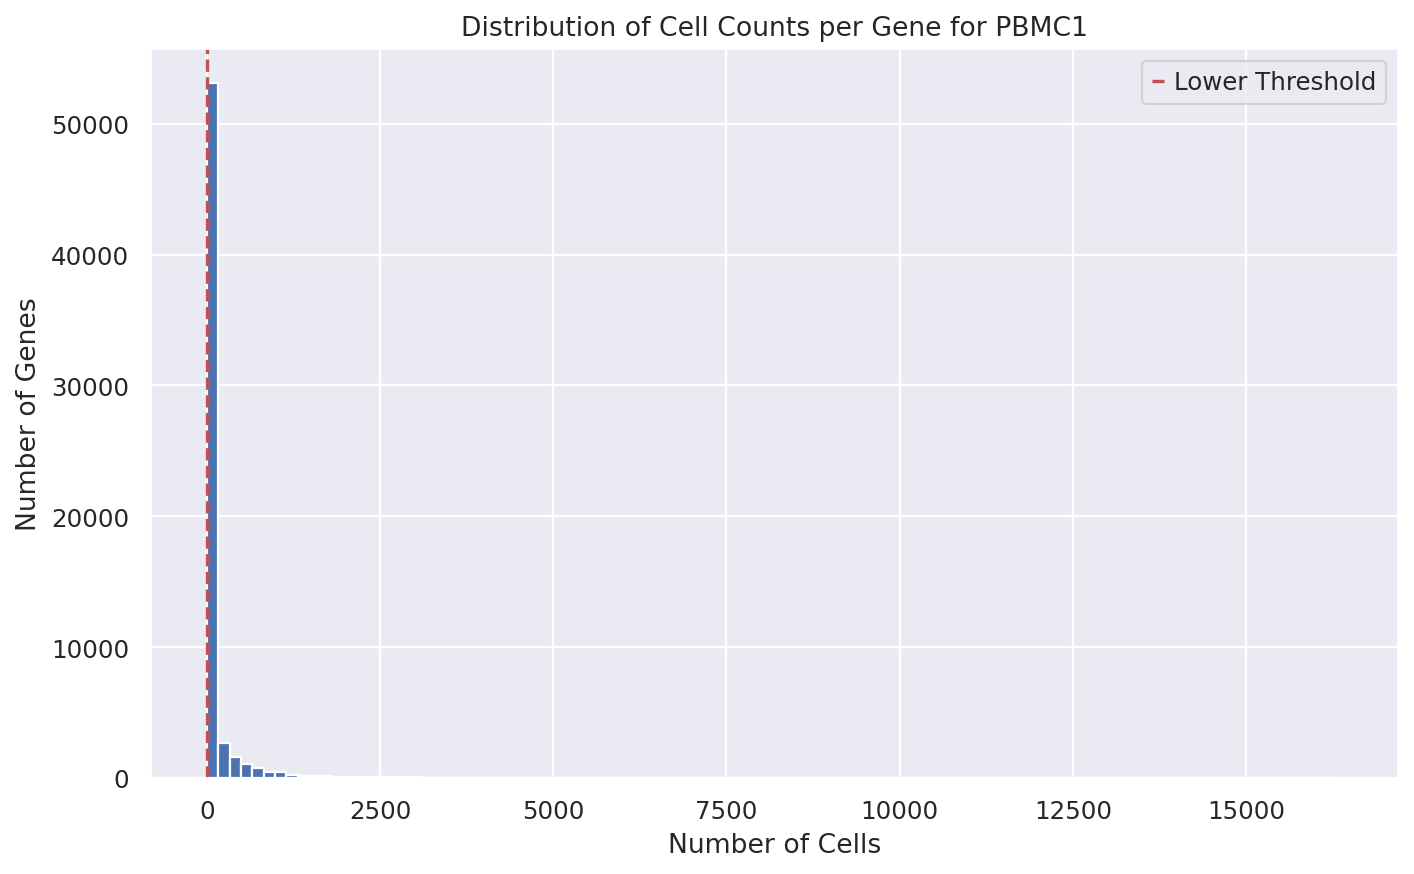

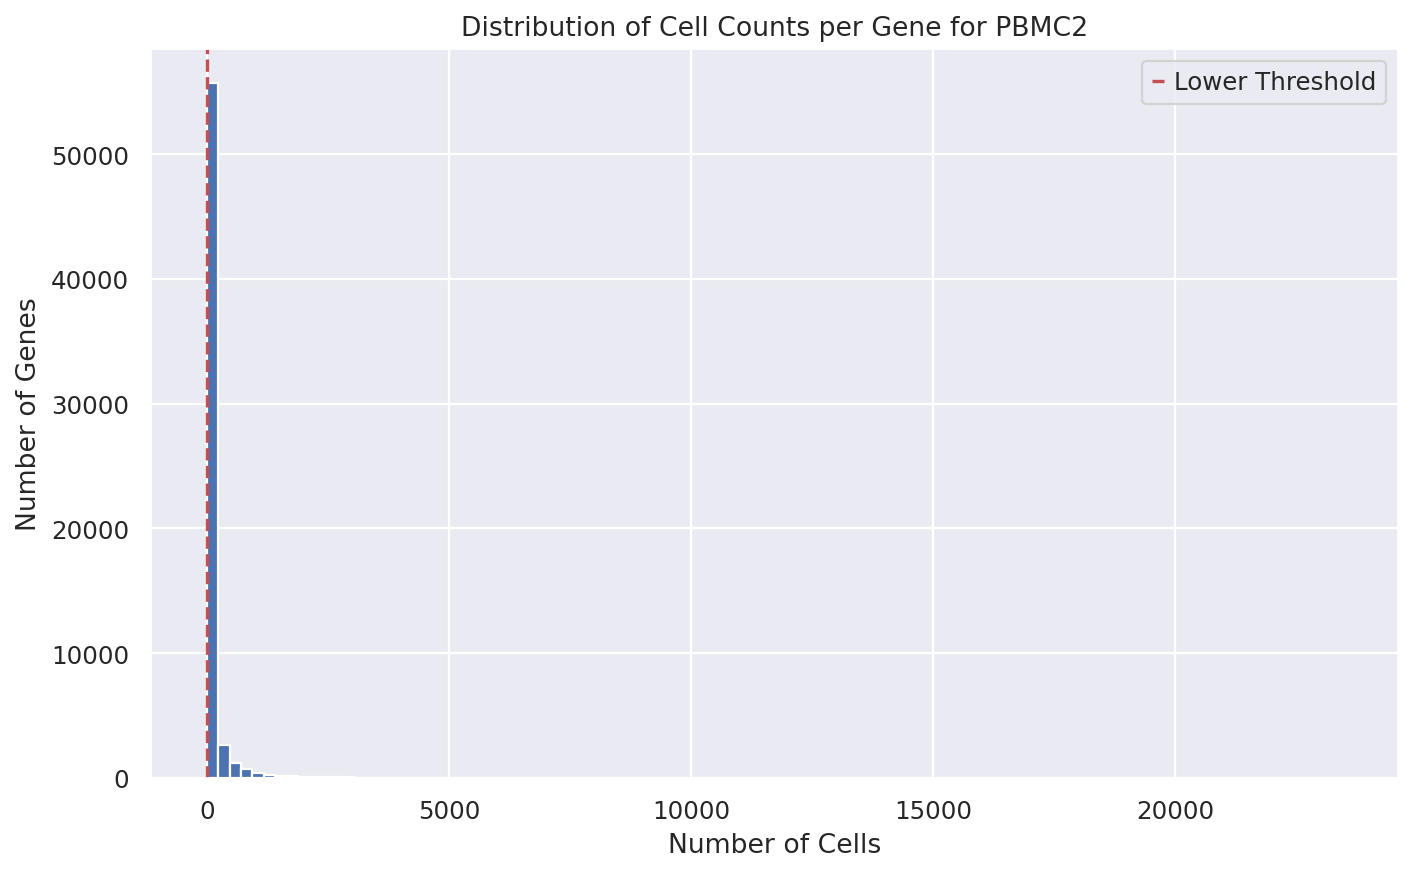

In [32]:
# Plot the distribution of cell counts per gene
plt.figure(figsize=(10, 6))
plt.hist(PBMC1_gene_counts, bins=100)
plt.xlabel('Number of Cells')
plt.ylabel('Number of Genes')
plt.title('Distribution of Cell Counts per Gene for PBMC1')
plt.axvline(5, color='r', linestyle='--', label='Lower Threshold')
plt.legend()
plt.show()

# Plot the distribution of cell counts per gene
plt.figure(figsize=(10, 6))
plt.hist(PBMC2_gene_counts, bins=100)
plt.xlabel('Number of Cells')
plt.ylabel('Number of Genes')
plt.title('Distribution of Cell Counts per Gene for PBMC2')
plt.axvline(5, color='r', linestyle='--', label='Lower Threshold')
plt.legend()
plt.show()

In [33]:
# Identify genes detected in fewer than the lower threshold of cells (e.g., 5 cells)
lower_threshold = 5
PBMC1_genes_to_remove = PBMC1_gene.var_names[PBMC1_gene_counts < lower_threshold]
PBMC2_genes_to_remove = PBMC2_gene.var_names[PBMC2_gene_counts < lower_threshold]

# Display the genes that will be removed
print("Genes to remove from PBMC1:", PBMC1_genes_to_remove)
print("Genes to remove from PBMC2:", PBMC2_genes_to_remove)

Genes to remove from PBMC1: Index(['TNMD:ENSG00000000005', 'SEMA3F:ENSG00000001617',
       'CFTR:ENSG00000001626', 'MYH16:ENSG00000002079', 'AOC1:ENSG00000002726',
       'HECW1:ENSG00000002746', 'CYP26B1:ENSG00000003137',
       'SLC7A2:ENSG00000003989', 'HSPB6:ENSG00000004776',
       'SLC22A16:ENSG00000004809',
       ...
       ':ENSG00000290105', ':ENSG00000290106', ':ENSG00000290107',
       ':ENSG00000290112', ':ENSG00000290113', ':ENSG00000290116',
       ':ENSG00000290118', 'GUCA1ANB-GUCA1A:ENSG00000290147',
       ':ENSG00000290162', ':ENSG00000290166'],
      dtype='object', name='combined_IDs', length=40390)
Genes to remove from PBMC2: Index(['TNMD:ENSG00000000005', 'SEMA3F:ENSG00000001617',
       'CFTR:ENSG00000001626', 'MYH16:ENSG00000002079', 'AOC1:ENSG00000002726',
       'HECW1:ENSG00000002746', 'CYP26B1:ENSG00000003137',
       'SLC7A2:ENSG00000003989', 'HSPB6:ENSG00000004776',
       'SLC22A16:ENSG00000004809',
       ...
       ':ENSG00000290106', ':ENSG0000029010

In [38]:
# Assuming PBMC1_gene is an AnnData object, extract the isoform IDs from var_names
P1_isoform_IDs = PBMC1_iso.var_names

# Convert to a list (if needed)
P1_isoform_ID_list = P1_isoform_IDs.tolist()

# Print the first few isoform IDs to verify
print(P1_isoform_ID_list[:10])  # Show the first 10 isoform IDs

# Assuming PBMC1_gene is an AnnData object, extract the isoform IDs from var_names
P2_isoform_IDs = PBMC2_iso.var_names

# Convert to a list (if needed)
P2_isoform_ID_list = P2_isoform_IDs.tolist()

# Print the first few isoform IDs to verify
print(P2_isoform_ID_list[:10])  # Show the first 10 isoform IDs

['nan:ENSG00000000003:ENST00000614008', 'TSPAN6:ENSG00000000003:ENST00000496771', 'TSPAN6:ENSG00000000003:ENST00000612152', 'TSPAN6:ENSG00000000003:ENST00000373020', 'TSPAN6:ENSG00000000003:ENST00000494424', 'TNMD:ENSG00000000005:ENST00000373031', 'TNMD:ENSG00000000005:ENST00000485971', 'DPM1:ENSG00000000419:ENST00000371582', 'DPM1:ENSG00000000419:ENST00000371584', 'DPM1:ENSG00000000419:ENST00000371588']
['nan:ENSG00000000003:ENST00000614008', 'TSPAN6:ENSG00000000003:ENST00000496771', 'TSPAN6:ENSG00000000003:ENST00000612152', 'TSPAN6:ENSG00000000003:ENST00000373020', 'TSPAN6:ENSG00000000003:ENST00000494424', 'TNMD:ENSG00000000005:ENST00000373031', 'TNMD:ENSG00000000005:ENST00000485971', 'DPM1:ENSG00000000419:ENST00000371582', 'DPM1:ENSG00000000419:ENST00000371584', 'DPM1:ENSG00000000419:ENST00000371588']


In [ ]:
# Filter the isoform IDs based on both GENEID and ENSEMBLEID
# Filter the isoform IDs based on the GENEID:ENSEMBLEID combinations to remove
# Define a function to filter isoforms based on GENEID:ENSEMBLEID
def filter_isoform_data(adata, genes_to_remove):
    # Extract the isoform IDs (var_names) in the format GENEID:ENSEMBLEID:ISOFORMID
    isoform_ids = adata.var_names
    
    # Filter out isoforms where GENEID:ENSEMBLEID matches the ones to remove
    mask = ~isoform_ids.str.startswith(tuple(genes_to_remove))  # Create a mask for isoforms to keep
    
    # Filter the AnnData object
    adata_filtered = adata[:, mask].copy()  # Filter the columns (features/isoforms) based on the mask
    
    return adata_filtered

# Filter PBMC1 and PBMC2 isoform data based on the combined genes to remove
filtered_PBMC1_iso = filter_isoform_data(PBMC1_iso, PBMC1_genes_to_remove)
filtered_PBMC2_iso = filter_isoform_data(PBMC2_iso, PBMC2_genes_to_remove)
filtered_PBMC1_gene = filter_isoform_data(PBMC1_gene, PBMC1_genes_to_remove)
filtered_PBMC2_gene = filter_isoform_data(PBMC2_gene, PBMC2_genes_to_remove)

# Display the filtered isoform data shapes
print("Filtered PBMC1 isoform data shape:", filtered_PBMC1_iso.shape)
print("Filtered PBMC2 isoform data shape:", filtered_PBMC2_iso.shape)

In [ ]:
# Define quality control thresholds per cell
mt_upper_threshold = 15
hb_lower_threshold = 5
hb_upper_threshold = 94
total_counts_lower_threshold = 200
total_counts_upper_threshold = 15000
n_genes_lower_threshold = 250
n_genes_upper_threshold = 2500

# Define the lower threshold for cell counts per gene
#lower_threshold = 5

In [ ]:
def plot_violin_with_thresholds(adata, metric, lower_thresh=None, upper_thresh=None, ax=None):
    sns.violinplot(data=adata.obs, y=metric, ax=ax, inner=None, density_norm='width')
    sns.stripplot(data=adata.obs, y=metric, ax=ax, color='k', jitter=True, size=1.5)
    
    if lower_thresh is not None:
        ax.axhline(y=lower_thresh, color='r', linestyle='--')
    if upper_thresh is not None:
        ax.axhline(y=upper_thresh, color='r', linestyle='--')
        
    ax.set_title(metric)
    
    # Add padding to the y-axis limits for all plots
    ymin = adata.obs[metric].min() - (0.05 * adata.obs[metric].max())  # Add padding below the min value
    ymax = adata.obs[metric].max() + (0.05 * adata.obs[metric].max())  # Add padding above the max value
    ax.set_ylim(ymin, ymax)

In [ ]:
# PBMC1 Initial Violin plots Pre-processing
# Plot for PBMC1_gene
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

plot_violin_with_thresholds(PBMC1_gene, "n_genes_by_counts", lower_thresh=n_genes_lower_threshold, upper_thresh=n_genes_upper_threshold, ax=axs[0, 0])
plot_violin_with_thresholds(PBMC1_gene, "total_counts", lower_thresh=total_counts_lower_threshold, upper_thresh=total_counts_upper_threshold, ax=axs[0, 1])
plot_violin_with_thresholds(PBMC1_gene, "pct_counts_mt", upper_thresh=mt_upper_threshold, ax=axs[1, 0])
plot_violin_with_thresholds(PBMC1_gene, "pct_counts_hb", lower_thresh=hb_lower_threshold, upper_thresh=hb_upper_threshold, ax=axs[1, 1])

plt.tight_layout()
plt.show()

In [ ]:
sc.pl.scatter(PBMC1_gene, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

In [ ]:
# PBMC2 Initial Violin plots Pre-processing
# Plot for PBMC2_gene
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

plot_violin_with_thresholds(PBMC2_gene, "n_genes_by_counts", lower_thresh=n_genes_lower_threshold, upper_thresh=n_genes_upper_threshold, ax=axs[0, 0])
plot_violin_with_thresholds(PBMC2_gene, "total_counts", lower_thresh=total_counts_lower_threshold, upper_thresh=total_counts_upper_threshold, ax=axs[0, 1])
plot_violin_with_thresholds(PBMC2_gene, "pct_counts_mt", upper_thresh=mt_upper_threshold, ax=axs[1, 0])
plot_violin_with_thresholds(PBMC2_gene, "pct_counts_hb", lower_thresh=hb_lower_threshold, upper_thresh=hb_upper_threshold, ax=axs[1, 1])

plt.tight_layout()
plt.show()

In [ ]:
sc.pl.scatter(PBMC2_gene, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

In [ ]:
# Calculate depth-to-gene count ratio
PBMC1_gene.obs['depth_to_gene_ratio'] = PBMC1_gene.obs['total_counts'] / PBMC1_gene.obs['n_genes_by_counts']
PBMC2_gene.obs['depth_to_gene_ratio'] = PBMC2_gene.obs['total_counts'] / PBMC2_gene.obs['n_genes_by_counts']

In [ ]:
# Define the ratio thresholds using customizable percentiles
lower_percentile = 3
upper_percentile = 97

PBMC1_lower_ratio_threshold = np.percentile(PBMC1_gene.obs['depth_to_gene_ratio'], lower_percentile)
PBMC1_upper_ratio_threshold = np.percentile(PBMC1_gene.obs['depth_to_gene_ratio'], upper_percentile)

PBMC2_lower_ratio_threshold = np.percentile(PBMC2_gene.obs['depth_to_gene_ratio'], lower_percentile)
PBMC2_upper_ratio_threshold = np.percentile(PBMC2_gene.obs['depth_to_gene_ratio'], upper_percentile)

In [ ]:
# Calculate the corresponding thresholds for n_genes_by_counts and total_counts
PBMC1_n_genes_lower_threshold = PBMC1_gene.obs['total_counts'].mean() / PBMC1_upper_ratio_threshold
PBMC1_n_genes_upper_threshold = PBMC1_gene.obs['total_counts'].mean() / PBMC1_lower_ratio_threshold

PBMC1_total_counts_lower_threshold = PBMC1_gene.obs['n_genes_by_counts'].mean() * PBMC1_lower_ratio_threshold
PBMC1_total_counts_upper_threshold = PBMC1_gene.obs['n_genes_by_counts'].mean() * PBMC1_upper_ratio_threshold

PBMC2_n_genes_lower_threshold = PBMC2_gene.obs['total_counts'].mean() / PBMC2_upper_ratio_threshold
PBMC2_n_genes_upper_threshold = PBMC2_gene.obs['total_counts'].mean() / PBMC2_lower_ratio_threshold

PBMC2_total_counts_lower_threshold = PBMC2_gene.obs['n_genes_by_counts'].mean() * PBMC2_lower_ratio_threshold
PBMC2_total_counts_upper_threshold = PBMC2_gene.obs['n_genes_by_counts'].mean() * PBMC2_upper_ratio_threshold

print(f"PBMC1 Lower ratio threshold: {PBMC1_lower_ratio_threshold}")
print(f"PBMC1 Upper ratio threshold: {PBMC1_upper_ratio_threshold}")
print(f"PBMC2 Lower ratio threshold: {PBMC2_lower_ratio_threshold}")
print(f"PBMC2 Upper ratio threshold: {PBMC2_upper_ratio_threshold}")

print(f"PBMC1_n_genes_lower_threshold: {PBMC1_n_genes_lower_threshold}")
print(f"PBMC1_n_genes_upper_threshold: {PBMC1_n_genes_upper_threshold}")
print(f"PBMC1_total_counts_lower_threshold: {PBMC1_total_counts_lower_threshold}")
print(f"PBMC1_total_counts_upper_threshold: {PBMC1_total_counts_upper_threshold}")

print(f"PBMC2_n_genes_lower_threshold: {PBMC2_n_genes_lower_threshold}")
print(f"PBMC2_n_genes_upper_threshold: {PBMC2_n_genes_upper_threshold}")
print(f"PBMC2_total_counts_lower_threshold: {PBMC2_total_counts_lower_threshold}")
print(f"PBMC2_total_counts_upper_threshold: {PBMC2_total_counts_upper_threshold}")

In [ ]:
# Plotting the results with the ratio-based thresholds
fig, axs = plt.subplots(3, 2, figsize=(15, 15))

plot_violin_with_thresholds(PBMC1_gene, "n_genes_by_counts", lower_thresh=PBMC1_n_genes_lower_threshold.min(), upper_thresh=PBMC1_n_genes_upper_threshold.max(), ax=axs[0, 0])
plot_violin_with_thresholds(PBMC1_gene, "total_counts", lower_thresh=PBMC1_total_counts_lower_threshold.min(), upper_thresh=PBMC1_total_counts_upper_threshold.max(), ax=axs[0, 1])
plot_violin_with_thresholds(PBMC1_gene, "depth_to_gene_ratio", lower_thresh=PBMC1_lower_ratio_threshold, upper_thresh=PBMC1_upper_ratio_threshold, ax=axs[1, 0])
plot_violin_with_thresholds(PBMC1_gene, "pct_counts_mt", upper_thresh=15, ax=axs[1, 1])
plot_violin_with_thresholds(PBMC1_gene, "pct_counts_hb", lower_thresh=3, upper_thresh=94, ax=axs[2, 0])

plt.tight_layout()
plt.show()

In [ ]:
# Plotting the results with the ratio-based thresholds
fig, axs = plt.subplots(3, 2, figsize=(15, 15))

plot_violin_with_thresholds(PBMC2_gene, "n_genes_by_counts", lower_thresh=PBMC2_n_genes_lower_threshold.min(), upper_thresh=PBMC2_n_genes_upper_threshold.max(), ax=axs[0, 0])
plot_violin_with_thresholds(PBMC2_gene, "total_counts", lower_thresh=PBMC2_total_counts_lower_threshold.min(), upper_thresh=PBMC2_total_counts_upper_threshold.max(), ax=axs[0, 1])
plot_violin_with_thresholds(PBMC2_gene, "depth_to_gene_ratio", lower_thresh=PBMC2_lower_ratio_threshold, upper_thresh=PBMC2_upper_ratio_threshold, ax=axs[1, 0])
plot_violin_with_thresholds(PBMC2_gene, "pct_counts_mt", upper_thresh=15, ax=axs[1, 1])
plot_violin_with_thresholds(PBMC2_gene, "pct_counts_hb", lower_thresh=3, upper_thresh=94, ax=axs[2, 0])

plt.tight_layout()
plt.show()

In [ ]:
# Initialize variables to store intermediate results
PBMC1_filtered = PBMC1_gene.copy()
PBMC2_filtered = PBMC2_gene.copy()

# Apply each filter step-by-step for PBMC1
total_counts_filter_1 = PBMC1_filtered.obs['total_counts'].between(PBMC1_total_counts_lower_threshold, PBMC1_total_counts_upper_threshold)
print(f"Total counts filter PBMC1: {total_counts_filter_1.sum()} cells remaining")

n_genes_filter_1 = PBMC1_filtered.obs['n_genes_by_counts'].between(PBMC1_n_genes_lower_threshold, PBMC1_n_genes_upper_threshold)
print(f"N genes filter PBMC1: {n_genes_filter_1.sum()} cells remaining")

mt_filter_1 = PBMC1_filtered.obs['pct_counts_mt'] < mt_upper_threshold
print(f"MT filter PBMC1: {mt_filter_1.sum()} cells remaining")

# Correct hemoglobin filter condition to keep cells with hb% > 94% or < 5%
hb_filter_1 = (PBMC1_filtered.obs['pct_counts_hb'] > hb_upper_threshold) | (PBMC1_filtered.obs['pct_counts_hb'] < hb_lower_threshold)
print(f"HB filter PBMC1: {hb_filter_1.sum()} cells remaining")

# Apply each filter step-by-step for PBMC2
total_counts_filter_2 = PBMC2_filtered.obs['total_counts'].between(PBMC2_total_counts_lower_threshold, PBMC2_total_counts_upper_threshold)
print(f"Total counts filter PBMC2: {total_counts_filter_2.sum()} cells remaining")

n_genes_filter_2 = PBMC2_filtered.obs['n_genes_by_counts'].between(PBMC2_n_genes_lower_threshold, PBMC2_n_genes_upper_threshold)
print(f"N genes filter PBMC2: {n_genes_filter_2.sum()} cells remaining")

mt_filter_2 = PBMC2_filtered.obs['pct_counts_mt'] < mt_upper_threshold
print(f"MT filter PBMC2: {mt_filter_2.sum()} cells remaining")

# Correct hemoglobin filter condition to keep cells with hb% > 94% or < 5%
hb_filter_2 = (PBMC2_filtered.obs['pct_counts_hb'] > hb_upper_threshold) | (PBMC2_filtered.obs['pct_counts_hb'] < hb_lower_threshold)
print(f"HB filter PBMC2: {hb_filter_2.sum()} cells remaining")


In [ ]:
## Filter cells based on quality control metrics

#PBMC1_gene = PBMC1_gene[
#    (PBMC1_gene.obs['total_counts'].between(total_counts_lower_threshold, total_counts_upper_threshold)) & 
#    (PBMC1_gene.obs['n_genes_by_counts'].between(n_genes_lower_threshold, n_genes_upper_threshold)) & 
#    (PBMC1_gene.obs['pct_counts_mt'] < mt_upper_threshold) & 
#    (PBMC1_gene.obs ['pct_counts_hb'] < hb_lower_threshold) 
#    (PBMC1_gene.obs ['pct_counts_hb'] > hb_upper_threshold), :
#]
#sc.pp.filter_genes(PBMC1_gene, min_cells=lower_threshold)

#PBMC2_gene = PBMC2_gene[
#    (PBMC2_gene.obs['total_counts'].between(total_counts_lower_threshold, total_counts_upper_threshold)) & 
#    (PBMC2_gene.obs['n_genes_by_counts'].between(n_genes_lower_threshold, n_genes_upper_threshold)) & 
#    (PBMC2_gene.obs['pct_counts_mt'] < mt_upper_threshold) & 
#    (PBMC2_gene.obs ['pct_counts_hb'] < hb_lower_threshold) 
#    (PBMC2_gene.obs ['pct_counts_hb'] > hb_upper_threshold), :
#]
#sc.pp.filter_genes(PBMC2_gene, min_cells=lower_threshold)

# Filter cells based on quality control metrics
# Apply all filters together
PBMC1_filtered = PBMC1_gene[
    total_counts_filter_1 & 
    n_genes_filter_1 & 
    mt_filter_1 & 
    hb_filter_1, :
]
sc.pp.filter_genes(PBMC1_filtered, min_cells=lower_threshold)

PBMC2_filtered = PBMC2_gene[
    total_counts_filter_2 & 
    n_genes_filter_2 & 
    mt_filter_2 & 
    hb_filter_2, :
]
sc.pp.filter_genes(PBMC2_filtered, min_cells=lower_threshold)

In [ ]:
# Remove any NaN values
PBMC1_gene_filtered = PBMC1_filtered[~np.isnan(PBMC1_filtered.X).any(axis=1)]
PBMC2_gene_filtered = PBMC2_filtered[~np.isnan(PBMC2_filtered.X).any(axis=1)]

In [ ]:
# Post QC cell counts
post_qc_cell_counts_1 = PBMC1_gene_filtered.n_obs
post_qc_cell_counts_2 = PBMC2_gene_filtered.n_obs

post_qc_cell_counts_df = pd.DataFrame({
    'Sample': ['PBMC1', 'PBMC2'],
    'Initial Counts': [PBMC1_gene.n_obs, PBMC2_gene.n_obs],
    'Post QC Counts': [post_qc_cell_counts_1, post_qc_cell_counts_2],
    'Percent Remaining': [post_qc_cell_counts_1 / PBMC1_gene.n_obs * 100, post_qc_cell_counts_2 / PBMC2_gene.n_obs * 100]
})

print(post_qc_cell_counts_df)

In [ ]:
# Recalculate the number of cells in which each gene is detected after filtering
PBMC1_gene_counts_filtered = np.sum(PBMC1_gene_filtered.X > 0, axis=0).A1 if isinstance(PBMC1_gene_filtered.X, np.matrix) else np.sum(PBMC1_gene_filtered.X > 0, axis=0)

PBMC2_gene_counts_filtered = np.sum(PBMC2_gene_filtered.X > 0, axis=0).A1 if isinstance(PBMC2_gene_filtered.X, np.matrix) else np.sum(PBMC2_gene_filtered.X > 0, axis=0)

In [ ]:
# Plot the distribution of cell counts per gene after filtering
plt.figure(figsize=(10, 6))
plt.hist(PBMC1_gene_counts_filtered, bins=100)
plt.xlabel('Number of Cells')
plt.ylabel('Number of Genes')
plt.title('Distribution of Cell Counts per Gene (Filtered)--PBMC1')
plt.axvline(lower_threshold, color='r', linestyle='--', label='Lower Threshold')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(PBMC2_gene_counts_filtered, bins=100)
plt.xlabel('Number of Cells')
plt.ylabel('Number of Genes')
plt.title('Distribution of Cell Counts per Gene (Filtered)--PBMC2')
plt.axvline(lower_threshold, color='r', linestyle='--', label='Lower Threshold')
plt.legend()
plt.show()

In [ ]:
# PBMC1 Violin plots Post-processing
# Plotting the results with the ratio-based thresholds
fig, axs = plt.subplots(3, 2, figsize=(15, 15))

plot_violin_with_thresholds(PBMC1_gene_filtered, "n_genes_by_counts", lower_thresh=PBMC2_n_genes_lower_threshold.min(), upper_thresh=PBMC2_n_genes_upper_threshold.max(), ax=axs[0, 0])
plot_violin_with_thresholds(PBMC1_gene_filtered, "total_counts", lower_thresh=PBMC2_total_counts_lower_threshold.min(), upper_thresh=PBMC2_total_counts_upper_threshold.max(), ax=axs[0, 1])
plot_violin_with_thresholds(PBMC1_gene_filtered, "depth_to_gene_ratio", lower_thresh=PBMC2_lower_ratio_threshold, upper_thresh=PBMC2_upper_ratio_threshold, ax=axs[1, 0])
plot_violin_with_thresholds(PBMC1_gene_filtered, "pct_counts_mt", upper_thresh=15, ax=axs[1, 1])
plot_violin_with_thresholds(PBMC1_gene_filtered, "pct_counts_hb", lower_thresh=5 , upper_thresh=94, ax=axs[2, 0])

plt.tight_layout()
plt.show()

In [ ]:
# PBMC1 Violin plots Post-processing
# Plotting the results with the ratio-based thresholds
fig, axs = plt.subplots(3, 2, figsize=(15, 15))

plot_violin_with_thresholds(PBMC1_gene_filtered, "n_genes_by_counts", lower_thresh=PBMC2_n_genes_lower_threshold.min(), upper_thresh=PBMC2_n_genes_upper_threshold.max(), ax=axs[0, 0])
plot_violin_with_thresholds(PBMC1_gene_filtered, "total_counts", lower_thresh=PBMC2_total_counts_lower_threshold.min(), upper_thresh=PBMC2_total_counts_upper_threshold.max(), ax=axs[0, 1])
plot_violin_with_thresholds(PBMC1_gene_filtered, "depth_to_gene_ratio", lower_thresh=PBMC2_lower_ratio_threshold, upper_thresh=PBMC2_upper_ratio_threshold, ax=axs[1, 0])
plot_violin_with_thresholds(PBMC1_gene_filtered, "pct_counts_mt", upper_thresh=15, ax=axs[1, 1])
plot_violin_with_thresholds(PBMC1_gene_filtered, "pct_counts_hb", lower_thresh=5, upper_thresh=94, ax=axs[2, 0])

plt.tight_layout()
plt.show()

In [ ]:
# Save the AnnData objects
PBMC1_gene_filtered.write("PBMC1_gene_filtered.h5ad")
PBMC2_gene_filtered.write("PBMC2_gene_filtered.h5ad")

In [2]:
from anndata import read_h5ad

# Define the folder path
folder_path = "SCVI_python_files"

# Load the AnnData objects
#PBMC1_gene_filtered = read_h5ad(os.path.join(folder_path, "PBMC1_gene_filtered.h5ad"))
#PBMC2_gene_filtered = read_h5ad(os.path.join(folder_path, "PBMC2_gene_filtered.h5ad"))
PBMC1_gene = read_h5ad(os.path.join(folder_path, "PBMC1_gene_filtered_standard.h5ad"))
PBMC2_gene = read_h5ad(os.path.join(folder_path, "PBMC2_gene_filtered_standard.h5ad"))
PBMC1_iso = read_h5ad(os.path.join(folder_path, "PBMC1_iso_filtered_standard.h5ad"))
PBMC2_iso = read_h5ad(os.path.join(folder_path, "PBMC2_iso_filtered_standard.h5ad"))

NameError: name 'PBMC1_gene_filtered' is not defined

In [3]:
# Verify the structure
print(PBMC1_gene)
print(PBMC2_gene)
print(PBMC1_iso)
print(PBMC2_iso)

AnnData object with n_obs × n_vars = 12588 × 170595
    obs: 'cell_ids', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb'
    var: 'isoform_ids', 'mt', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
AnnData object with n_obs × n_vars = 21919 × 165586
    obs: 'cell_ids', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb'
    var: 'isoform_ids', 'mt', 'hb', 'n_

In [4]:
# Check for initial NaN values
#print("Initial NaN values in the data matrix:", np.isnan(PBMC1_gene_filtered.X).sum())
#print("Initial NaN values in the data matrix:", np.isnan(PBMC2_gene_filtered.X).sum())
print("Initial NaN values in PBMC1_gene:", np.isnan(PBMC1_gene.X).sum())
print("Initial NaN values in PBMC2_gene:", np.isnan(PBMC2_gene.X).sum())
print("Initial NaN values in PBMC1_iso:", np.isnan(PBMC1_iso.X).sum())
print("Initial NaN values in PBMC2_iso:", np.isnan(PBMC2_iso.X).sum())

Initial NaN values in PBMC1_gene: 0
Initial NaN values in PBMC2_gene: 0
Initial NaN values in PBMC1_iso: 0
Initial NaN values in PBMC2_iso: 0


In [11]:
# Adding the sample column to each AnnData object
PBMC1_gene.obs['sample'] = 'PBMC1_gene'
PBMC2_gene.obs['sample'] = 'PBMC2_gene'
PBMC1_iso.obs['sample'] = 'PBMC1_iso'
PBMC2_iso.obs['sample'] = 'PBMC2_iso'

# Function to compute and display summary stats
def compute_summary_stats(adata,  is_isoform=False):
    print(f"### Summary Stats for sample: {adata.obs['sample'].unique()[0]}")
    
    # Genes or Isoforms per Cell (nFeature_RNA)
    unique_features_per_cell = adata.obs['n_genes_by_counts']
    print("\n---", "Unique Isoforms" if is_isoform else "Unique Genes", "per Cell ---")
    print(f"Min: {unique_features_per_cell.min()}")
    print(f"1st Quartile: {np.quantile(unique_features_per_cell, 0.25)}")
    print(f"Median: {np.median(unique_features_per_cell)}")
    print(f"Mean: {unique_features_per_cell.mean()}")
    print(f"3rd Quartile: {np.quantile(unique_features_per_cell, 0.75)}")
    print(f"Max: {unique_features_per_cell.max()}")
    
    # Transcripts per Gene (nCount_RNA / nFeature_RNA) - Only for gene-level data
    if not is_isoform:
        transcripts_per_gene = adata.obs['total_counts'] / adata.obs['n_genes_by_counts']
        print("\n--- Transcripts per Gene ---")
        print(f"Min: {np.min(transcripts_per_gene)}")
        print(f"1st Quartile: {np.quantile(transcripts_per_gene, 0.25)}")
        print(f"Median: {np.median(transcripts_per_gene)}")
        print(f"Mean: {np.mean(transcripts_per_gene)}")
        print(f"3rd Quartile: {np.quantile(transcripts_per_gene, 0.75)}")
        print(f"Max: {np.max(transcripts_per_gene)}")

        # Mitochondrial Percentage (percent.mt)
        mt_percentage = adata.obs['pct_counts_mt']
        print("\n--- Mitochondrial Percentage ---")
        print(f"Min: {mt_percentage.min()}")
        print(f"1st Quartile: {np.quantile(mt_percentage, 0.25)}")
        print(f"Median: {np.median(mt_percentage)}")
        print(f"Mean: {mt_percentage.mean()}")
        print(f"3rd Quartile: {np.quantile(mt_percentage, 0.75)}")
        print(f"Max: {mt_percentage.max()}")
    else:
        # Reads per Isoform per Cell (Raw Counts) for isoform data
        reads_per_isoform_per_cell = np.array(adata.X.sum(axis=1)).flatten() / unique_features_per_cell
        print("\n--- Reads per Isoform per Cell (Raw Counts) ---")
        print(f"Min: {np.min(reads_per_isoform_per_cell)}")
        print(f"1st Quartile: {np.quantile(reads_per_isoform_per_cell, 0.25)}")
        print(f"Median: {np.median(reads_per_isoform_per_cell)}")
        print(f"Mean: {np.mean(reads_per_isoform_per_cell)}")
        print(f"3rd Quartile: {np.quantile(reads_per_isoform_per_cell, 0.75)}")
        print(f"Max: {np.max(reads_per_isoform_per_cell)}")

# Create gene and isoform samples (AnnData objects)
gene_samples = {
    'PBMC1_gene': PBMC1_gene, 
    'PBMC2_gene': PBMC2_gene
}

isoform_samples = {
    'PBMC1_iso': PBMC1_iso, 
    'PBMC2_iso': PBMC2_iso
}

# Compute summary stats for gene-level data
for sample_name, sample_data in gene_samples.items():
    print(f"\n=== Gene Summary for: {sample_name} ===")
    compute_summary_stats(sample_data)

# Compute summary stats for isoform-level data
for sample_name, sample_data in isoform_samples.items():
    print(f"\n=== Isoform Summary for: {sample_name} ===")
    compute_summary_stats(sample_data, is_isoform=True)


=== Gene Summary for: PBMC1_gene ===
### Summary Stats for sample: PBMC1_gene

--- Unique Genes per Cell ---
Min: 8
1st Quartile: 660.0
Median: 947.0
Mean: 962.4876072449953
3rd Quartile: 1229.0
Max: 2494

--- Transcripts per Gene ---
Min: 0.6046510174418603
1st Quartile: 1.5244087079465076
Median: 1.933588016278025
Mean: 2.665043039099329
3rd Quartile: 2.3671899377883054
Max: 62.39393969696969

--- Mitochondrial Percentage ---
Min: 0.0
1st Quartile: 5.929836243803607
Median: 7.48707277360093
Mean: 7.552452163027008
3rd Quartile: 9.386213036146433
Max: 14.993424199797003

=== Gene Summary for: PBMC2_gene ===
### Summary Stats for sample: PBMC2_gene

--- Unique Genes per Cell ---
Min: 14
1st Quartile: 408.0
Median: 516.0
Mean: 557.1302522925316
3rd Quartile: 650.0
Max: 2434

--- Transcripts per Gene ---
Min: 0.5678733257918551
1st Quartile: 1.2005000411353357
Median: 1.440591678224688
Mean: 1.8606482916788227
3rd Quartile: 1.6955415834994874
Max: 44.05882294117647

--- Mitochondrial Pe

In [7]:
import anndata

# Concatenate the two AnnData objects
adata = anndata.concat([PBMC1_gene_filtered, PBMC2_gene_filtered], join="inner", label="batch", keys=["PBMC1", "PBMC2"])

# Verify the result
print(adata)
print(adata.obs["batch"].value_counts())

NameError: name 'PBMC1_gene_filtered' is not defined

In [ ]:
# Save the AnnData objects
adata.write("Concatenated_Data.h5ad")

In [ ]:
from anndata import read_h5ad

# Define the folder path
folder_path = "SCVI_python_files"

# Load the AnnData objects
adata = read_h5ad(os.path.join(folder_path, "Concatenated_Data.h5ad"))

# Verify the structure
print(adata)

In [ ]:
# Check for initial NaN values
print("Initial NaN values in the data matrix:", np.isnan(adata.X).sum())

In [ ]:
#Check For Doublets
sc.pp.scrublet(adata, batch_key="batch")

In [ ]:
from skimage.filters import threshold_minimum

# Calculate the automatic threshold using Scrublet's method
automatic_threshold = threshold_minimum(adata.obs['doublet_score'].values)

# Set initial threshold to mark 14% of cells as doublets
manual_threshold = np.percentile(adata.obs['doublet_score'], 86)

# Debugging: Print the calculated manual threshold and check the 86th percentile
print(f"Manual threshold (86th percentile): {manual_threshold:.3f}")
print(f"86th percentile value in doublet scores: {np.percentile(adata.obs['doublet_score'], 86):.3f}")

In [ ]:
# Plot the histogram of doublet scores with both thresholds
plt.figure(figsize=(10, 6))
plt.hist(adata.obs['doublet_score'], bins=50, alpha=0.6, color='g')
plt.axvline(manual_threshold, color='r', linestyle='dashed', linewidth=2, label=f'Manual Threshold 14% ({manual_threshold:.3f})')
plt.axvline(automatic_threshold, color='b', linestyle='dashed', linewidth=2, label=f'Automatic Threshold ({automatic_threshold:.3f})')
plt.xlabel('Doublet Score')
plt.ylabel('Number of Cells')
plt.title('Distribution of Doublet Scores')
plt.legend()
plt.show()

In [ ]:
# Set final threshold to mark doublet score of 0.25 as threshold
final_threshold = 0.250


In [ ]:
# Plot the histogram of doublet scores with all 3 thresholds
plt.figure(figsize=(10, 6))
plt.hist(adata.obs['doublet_score'], bins=50, alpha=0.6, color='g')
plt.axvline(manual_threshold, color='r', linestyle='dashed', linewidth=2, label=f'Manual Threshold ({manual_threshold:.3f})')
plt.axvline(final_threshold, color='orange', linestyle='dashed', linewidth=2, label=f'Final Threshold ({final_threshold:.3f})')
plt.axvline(automatic_threshold, color='b', linestyle='dashed', linewidth=2, label=f'Automatic Threshold ({automatic_threshold:.3f})')
plt.xlabel('Doublet Score')
plt.ylabel('Number of Cells')
plt.title('Distribution of Doublet Scores')
plt.legend()
plt.show()

In [ ]:
# Add doublet scores to AnnData object
adata.obs['predicted_doublet_manual'] = adata.obs['doublet_score'] > manual_threshold
adata.obs['predicted_doublet_auto'] = adata.obs['doublet_score'] > automatic_threshold
adata.obs['predicted_doublet_final'] = adata.obs['doublet_score'] > final_threshold

print(f"Manual threshold: {manual_threshold}")
print(f"Automatic threshold: {automatic_threshold}")
print(f"Final threshold: {final_threshold}")
print(f"Number of cells predicted as doublets with manual threshold: {adata.obs['predicted_doublet_manual'].sum()}")
print(f"Number of cells predicted as doublets with automatic threshold: {adata.obs['predicted_doublet_auto'].sum()}")
print(f"Number of cells predicted as doublets with final threshold: {adata.obs['predicted_doublet_final'].sum()}")

In [ ]:
# Filter out predicted doublets using the final threshold
adata_filtered = adata[~adata.obs['predicted_doublet_final']]


print(f"Number of cells before filtering: {adata.shape[0]}")
print(f"Number of cells after filtering with final threshold: {adata_filtered.shape[0]}")

In [ ]:
# Check for initial NaN values
print("Initial NaN values in the data matrix:", np.isnan(adata_filtered.X).sum())

In [ ]:
## Many analyses require normalized data, however SCVI requires raw counts. This maintains raw counts.
adata_filtered.layers["counts"] = adata_filtered.X.copy()

In [ ]:
#Normalize the data
sc.pp.normalize_total(adata_filtered)
sc.pp.log1p(adata_filtered)

In [ ]:
## create a new MuData object where the normalized data are another “modality”
mdata = muon.MuData({"rna": adata_filtered.copy(), "log_norm_rna": adata_filtered.copy()}, axis=-1)
# Now rna is count-based and log_norm_rna is log-normalized
mdata.mod["rna"].X = mdata.mod["rna"].layers["counts"]
del mdata.mod["rna"].raw
del mdata.mod["rna"].layers["counts"]
del mdata.mod["log_norm_rna"].layers["counts"]
mdata

In [ ]:
# Extract the RNA modality
rna_adata = mdata.mod['rna']
# Ensure that the counts layer is set
rna_adata.layers["counts"] = rna_adata.X.copy()

In [ ]:
# Identify highly variable genes using 'seurat_v3' flavor
#sc.pp.highly_variable_genes(rna_adata, n_top_genes=2000, subset=True, layer='counts', flavor='seurat_v3', batch_key='batch')

In [ ]:
# Ensure the modifications are saved back to the MuData object
mdata.mod['rna'] = rna_adata
# Verify that the highly variable genes are correctly identified and subsetted
print(mdata.mod['rna'])

In [ ]:
# Proceed with scVI setup and model training using the identified highly variable genes
scvi.model.SCVI.setup_anndata(mdata.mod['rna'], layer='counts', batch_key='batch')

In [ ]:
# Create and train the SCVI model
SCVI_model = scvi.model.SCVI(mdata.mod["rna"], n_latent=20)
SCVI_model.train()

In [ ]:
scvi.model.AUTOZI.setup_anndata(
    mdata.mod['rna'], batch_key = 'batch'
)

autozi_model = scvi.model.AUTOZI(mdata.mod['rna'], n_latent=20)
autozi_model.train(max_epochs=200, plan_kwargs={'lr': 1e-2})

In [ ]:
# Get latent representation after AutoZI
latent_autozi = autozi_model.get_latent_representation()
outputs = autozi_model.get_alphas_betas()
alpha_posterior = outputs['alpha_posterior']
beta_posterior = outputs['beta_posterior']

latent = SCVI_model.get_latent_representation()

In [ ]:
# Ensure the latent representation has the correct row names
rna_cell_names = mdata.mod['rna'].obs_names

# Check the shape of the latent_autozi representation
print(f"Shape of latent_autozi: {latent_autozi.shape}")
print(f"Number of cells in mdata.mod['rna']: {mdata.mod['rna'].n_obs}")


In [ ]:
### If needed: Filter the latent_autozi and mdata.mod['rna'] to include only common cells
#latent_autozi_cell_names = rna_cell_names[:latent_autozi.shape[0]]  # Assuming the order was preserved

## Identify the intersection of cells between mdata.mod['rna'] and latent_autozi
#common_cells = np.intersect1d(rna_cell_names, latent_autozi_cell_names)

## Filter mdata.mod['rna'] to include only the common cells
#adata_filtered = mdata.mod['rna'][common_cells, :]

## Ensure the latent_autozi matrix is also filtered to include only the common cells
#latent_autozi_filtered = latent_autozi[np.isin(latent_autozi_cell_names, common_cells), :]

## Check that the number of cells now matches
#assert latent_autozi_filtered.shape[0] == adata_filtered.shape[0], "Mismatch between filtered latent space and adata_filtered."

## Add the SCVI latent space as well if it hasn’t been added yet
#latent_filtered = latent[np.isin(rna_cell_names, common_cells), :]

### If not needed: 
adata_filtered = mdata.mod['rna']
latent_autozi_filtered = latent_autozi
latent_filtered = latent

In [ ]:
# Step 2: Add the latent representation back to the AnnData object
adata_filtered.obsm['X_scvi_AutoZI'] = latent_autozi_filtered

# Optional: Add the SCVI latent space as well if it hasn’t been added yet
adata_filtered.obsm['X_scvi'] = latent_filtered

In [ ]:
# Step 3: Analyze Zero-Inflated (ZI) probabilities
threshold = 0.5
zi_probs = beta.cdf(threshold, alpha_posterior, beta_posterior)
is_zi_pred = zi_probs > threshold

print('Fraction of predicted ZI genes :', is_zi_pred.mean())

mask_sufficient_expression = (np.array(adata_filtered.X.mean(axis=0)) > 1.0).reshape(-1)
print('Fraction of genes with avg expression > 1.0 :', mask_sufficient_expression.mean())
print('Fraction of predicted ZI genes with avg expression > 1.0 :', is_zi_pred[mask_sufficient_expression].mean())


In [ ]:
# Save the model and associated MuData object
#model.save(output_dir, overwrite=True)
#mdata.write(os.path.join(output_dir, "mdata_object_with_latent.h5mu"))

# Define the output directory relative to the current working directory
scvi_dir = './SCVI_python_files/Models/All_Data/SCVI_model'
os.makedirs(scvi_dir, exist_ok=True)

autozi_dir = './SCVI_python_files/Models/All_Data/AUTOZI_model'
os.makedirs(autozi_dir, exist_ok=True)


# Step 4: Save the model and associated MuData object
SCVI_model.save(scvi_dir, overwrite=True)
autozi_model.save(autozi_dir, overwrite=True)
mdata.mod['rna'] = adata_filtered  # Ensure the filtered AnnData object is saved back to MuData
mdata.write(os.path.join(output_dir, "mdata_object_with_latent.h5mu"))

print("Model and data saved successfully.")


In [ ]:
import os
import scanpy as sc
import muon as mu
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scvi

output_dir = './SCVI_python_files'
autozi_dir = './SCVI_python_files/Models/All_Data/AUTOZI_model'
scvi_dir = './SCVI_python_files/Models/All_Data/SCVI_model'

# Load the mdata object from the file
mdata = mu.read(os.path.join(output_dir, "mdata_object_with_latent.h5mu"))

# Extract the RNA modality
adata = mdata.mod['rna']

# Load the AUTOZI model (assuming it was saved using the AUTOZI class)
try:
    autozi_model = scvi.model.AUTOZI.load(autozi_dir, adata=adata)
    print("AUTOZI model loaded successfully.")
except ValueError as e:
    print(f"Error loading AUTOZI model: {e}")
    autozi_model = None

# Load the SCVI model (assuming it was saved using the SCVI class)
try:
    scvi_model = scvi.model.SCVI.load(scvi_dir, adata=adata)
    print("SCVI model loaded successfully.")
except ValueError as e:
    print(f"Error loading SCVI model: {e}")
    scvi_model = None

# Proceed with further steps only if both AUTOZI and SCVI models are loaded successfully
if autozi_model is not None and scvi_model is not None:
    # Get latent representation after AutoZI and SCVI
    latent_autozi = autozi_model.get_latent_representation()
    latent_scvi = scvi_model.get_latent_representation()

    # Check that the latent representations have the correct row names
    rna_cell_names = adata.obs_names

    # Identify the intersection of cells between adata and latent representations
    common_cells = np.intersect1d(rna_cell_names, rna_cell_names[:latent_autozi.shape[0]])

    # Filter adata to include only the common cells
    adata_filtered = adata[common_cells, :]

    # Filter the latent matrices to include only the common cells
    latent_autozi_filtered = latent_autozi[np.isin(rna_cell_names, common_cells), :]
    latent_scvi_filtered = latent_scvi[np.isin(rna_cell_names, common_cells), :]

    # Add the latent representations back to the AnnData object
    adata_filtered.obsm['X_scvi_AutoZI'] = latent_autozi_filtered
    adata_filtered.obsm['X_scvi'] = latent_scvi_filtered

    # Save the updated MuData object with the latent representations
    mdata.mod['rna'] = adata_filtered
    mdata.write(os.path.join(output_dir, "mdata_object_with_latent.h5mu"))

    print("Both AUTOZI and SCVI model data saved successfully.")
else:
    print("Could not proceed as one or both models failed to load.")

In [ ]:
# Compute neighbors and UMAP using the scVI latent space
sc.pp.neighbors(adata_filtered, use_rep='X_scvi_AutoZI', n_neighbors=20)
sc.tl.umap(adata_filtered)

In [ ]:
# Perform Leiden clustering at multiple resolutions
resolutions = [0.4, 0.8, 1.0]
for res in resolutions:
    sc.tl.leiden(adata_filtered, resolution=res, key_added=f'{res}_clusters', flavor = "igraph", n_iterations=2)

In [ ]:
def relabel_clusters_by_size(adata_filtered, cluster_key):
    # Get the cluster labels
    cluster_labels = adata_filtered.obs[cluster_key]
    
    # Count the size of each cluster
    cluster_sizes = cluster_labels.value_counts()
    
    # Sort clusters by size (largest first)
    sorted_clusters = cluster_sizes.index[np.argsort(-cluster_sizes.values)]
    
    # Create a mapping from old cluster labels to new ones
    new_labels_map = {old_label: new_label for new_label, old_label in enumerate(sorted_clusters)}
    
    # Apply the new labels
    adata_filtered.obs[cluster_key] = cluster_labels.map(new_labels_map).astype('category')
    
    return adata_filtered

In [ ]:
print(adata_filtered.obs.keys())

In [ ]:
# Relabel clusters by size
resolutions = ['0.4_clusters', '0.8_clusters', '1.0_clusters']
for cluster_key in resolutions:
    adata_filtered = relabel_clusters_by_size(adata_filtered, cluster_key)

In [ ]:
# Perform marker analysis for a single resolution
sc.tl.rank_genes_groups(adata_filtered, groupby='0.4_clusters', method='wilcoxon', use_raw=False)

# Inspect the results
results = adata_filtered.uns['rank_genes_groups']
pvals = results['pvals']

# Print the first few p-values
print(pvals[:10])

In [ ]:
# Function to compute and store markers with scientific notation
def compute_and_store_markers_with_scientific_notation(adata_filtered, output_dir, resolutions):
    for res in resolutions:
        # Perform marker analysis (differential expression analysis with Wilcoxon test)
        sc.tl.rank_genes_groups(
            adata_filtered, 
            groupby=f'{res}_clusters', 
            method='wilcoxon',
            use_raw=False, 
            pts=True  # Calculates the fraction of cells in each cluster expressing each gene
        )
        
        # Extract the marker genes for each cluster
        results = adata_filtered.uns['rank_genes_groups']
        groups = results['names'].dtype.names
        
        # Initialize an empty DataFrame to collect markers for all clusters
        markers_all_clusters = pd.DataFrame()
        
        for group in groups:
            df = pd.DataFrame({
                'gene': results['names'][group],
                'logfoldchanges': results['logfoldchanges'][group],
                'pvals': results['pvals'][group],
                'pvals_adj': results['pvals_adj'][group],
                'scores': results['scores'][group],
                'pct_nz_group': results['pts'][group]
            })
            
            # Apply filters similar to the R code
            filtered_markers = df[
                (df['logfoldchanges'] > 0.5) &  # Filter based on log fold change threshold
                (df['pct_nz_group'] > 0.2)  & # Filter based on percentage of cells expressing the gene
                (df['pvals_adj'] < 0.05)
            ].copy()
            
            # Add a column indicating the cluster
            filtered_markers['cluster'] = group
            
            # Append to the markers DataFrame
            markers_all_clusters = pd.concat([markers_all_clusters, filtered_markers], ignore_index=True)
        
        # Save the markers DataFrame to a CSV file in the output directory with scientific notation
        markers_file_path = os.path.join(output_dir, f"markers_res_AUTOZI_{res}.csv")
        markers_all_clusters.to_csv(markers_file_path, index=False, float_format='%.8e')
        
        print(f"Markers for resolution {res} saved to {markers_file_path}")

    print("All marker files have been saved.")

In [ ]:
# Call the function
compute_and_store_markers_with_scientific_notation(adata_filtered, output_dir, resolutions=[0.4, 0.8, 1.0])

In [ ]:
# Function to plot UMAP with labels reflecting cluster sizes
def plot_umap_with_labels(adata_filtered, resolutions):
    for res in resolutions:
        # Plot UMAP with cluster labels
        sc.pl.umap(
            adata,
            color=f'{res}_clusters',
            title=f'UMAP with Clusters (Res={res})',
            frameon=True,
            legend_loc='on data',  # This places the labels directly on the UMAP
            legend_fontsize=10,
            legend_fontoutline=2,
        )

In [ ]:
# Call the functions
#compute_and_store_markers_with_relabeling(adata_filtered, output_dir, resolutions=[0.4, 0.8, 1.0])
plot_umap_with_labels(adata_filtered, resolutions=[0.4, 0.8, 1.0])

In [ ]:
from adjustText import adjust_text

# Prepare volcano plot data based on differential expression results
def prepare_volcano_data(adata_filtered):
    print("Preparing volcano plot data...")

    # Extract differential expression results
    results = adata_filtered.uns['rank_genes_groups']
    groups = results['names'].dtype.names
    
    # Initialize an empty DataFrame to store results for plotting
    volcano_data = pd.DataFrame()

    for group in groups:
        df = pd.DataFrame({
            'Gene': results['names'][group],
            'Log2FoldChange': results['logfoldchanges'][group],
            'PValue': results['pvals'][group],
            'PValueAdj': results['pvals_adj'][group]
        })

        # Calculate -Log10 PValue for plotting
        df['NegLog10PValue'] = -np.log10(df['PValue'] + 1e-10)

        # Append to the volcano_data DataFrame
        volcano_data = pd.concat([volcano_data, df], ignore_index=True)

    # Remove duplicates based on the 'Gene' column, keeping the highest absolute fold change
    volcano_data = volcano_data.loc[volcano_data.groupby('Gene')['Log2FoldChange'].idxmax()]

    print("Volcano data preparation complete. Here's a preview:")
    print(volcano_data.head())

    return volcano_data

# Create volcano plot
def plot_volcano(volcano_data, title='Volcano Plot for All Data', max_labels=30):
    print(f"Creating volcano plot: {title}...")

    plt.figure(figsize=(10, 8))
    sns.scatterplot(data=volcano_data, x='Log2FoldChange', y='NegLog10PValue', hue='PValueAdj', palette='viridis', edgecolor=None, legend=False)

    # Highlight genes with high significance and high fold change
    high_significance = (volcano_data['NegLog10PValue'] > 2) & (volcano_data['Log2FoldChange'].abs() > 1)
    highlight = volcano_data[high_significance]

    # Limit the number of labeled points to avoid memory issues
    highlight = highlight.nlargest(max_labels, 'NegLog10PValue')

    texts = []
    for i, row in highlight.iterrows():
        texts.append(plt.text(row['Log2FoldChange'], row['NegLog10PValue'], row['Gene'], fontsize=8, alpha=0.75))

    adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))

    plt.title(title)
    plt.xlabel('Log2 Fold Change')
    plt.ylabel('-Log10 P-value')
    plt.axhline(y=2, color='red', linestyle='dashed')  # Threshold for significance
    plt.axvline(x=1, color='blue', linestyle='dashed')  # Threshold for fold change
    plt.axvline(x=-1, color='blue', linestyle='dashed')
    plt.grid(True)
    plt.show()

    print("Volcano plot created successfully.")

In [ ]:
# Generate volcano plot for all data
volcano_data = prepare_volcano_data(adata_filtered)
plot_volcano(volcano_data, title='Volcano Plot for All Data', max_labels=30)

In [ ]:
# Define the number of rows and columns for the grid
nrows = 5
ncols = 4

# Create a figure with a grid of subplots
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 10))

# Flatten the axes array for easy indexing
axes = axes.flatten()

# Plot the top 10 genes with the highest absolute fold change
top_genes = volcano_data.nlargest(10, 'Log2FoldChange')['Gene']
for i, gene in enumerate(top_genes):
    sc.pl.umap(adata, color=gene, ax=axes[i], title=f"{gene}", show=False)

# Plot the top 10 genes with the highest negative fold change
top_negative_genes = volcano_data.nsmallest(10, 'Log2FoldChange')['Gene']
for i, gene in enumerate(top_negative_genes, start=len(top_genes)):
    sc.pl.umap(adata, color=gene, ax=axes[i], title=f"{gene} (Negative FC)", show=False)

# Remove any unused subplots
for j in range(len(top_genes) + len(top_negative_genes), len(axes)):
    fig.delaxes(axes[j])

# Adjust the layout
plt.tight_layout()
plt.show()

In [ ]:
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns

def plot_umap_with_cluster_labels(adata_filtered, cluster_key, title, palette='tab20'):
    """
    Plot UMAP with clusters labeled by their respective cluster numbers.
    
    Parameters:
    - adata: AnnData object containing the data.
    - cluster_key: The key in adata.obs that contains the cluster assignments.
    - title: The title of the plot.
    - palette: The color palette to use for the clusters.
    """
    # Ensure cluster labels are treated as strings
    adata_filtered.obs[cluster_key] = adata_filtered.obs[cluster_key].astype(str)
    
    # Set the color palette
    unique_clusters = adata_filtered.obs[cluster_key].unique()
    num_clusters = len(unique_clusters)
    colors = sns.color_palette(palette, num_clusters)
    cluster_palette = {str(cluster): color for cluster, color in zip(unique_clusters, colors)}

    # Plot the UMAP with clusters, disable the legend
    sc.pl.umap(adata_filtered, color=cluster_key, title=title, frameon=True, show=False, legend_loc=None, palette=cluster_palette)

    # Add cluster labels
    ax = plt.gca()
    for cluster in unique_clusters:
        # Get the integer indices of the cluster's cells
        indices = adata_filtered.obs[adata_filtered.obs[cluster_key] == cluster].index
        int_indices = [adata_filtered.obs.index.get_loc(i) for i in indices]
        
        # Calculate the centroid for the cluster
        centroid = adata_filtered.obsm['X_umap'][int_indices].mean(axis=0)
        ax.text(centroid[0], centroid[1], str(cluster), fontsize=12, weight='bold',
                color='black', ha='center', va='center', bbox=dict(facecolor='white', alpha=0.5, edgecolor='black', boxstyle='round,pad=0.3'))

    plt.show()

# Example usage:
resolutions = [0.4, 0.8, 1.0]
for res in resolutions:
    cluster_key = f"{res}_clusters"
    plot_umap_with_cluster_labels(adata_filtered, cluster_key, title=f"UMAP with Clusters (Res={res})")

In [ ]:
import scipy.sparse as sp

def perform_marker_analysis(adata_filtered, resolutions, output_dir):
    for res in resolutions:
        cluster_key = f"{res}_clusters"
        
        # Initialize an empty DataFrame to collect markers for all clusters
        markers_all_clusters = pd.DataFrame()

        # Perform marker analysis (differential expression analysis with Wilcoxon test)
        sc.tl.rank_genes_groups(
            adata,
            groupby=cluster_key,
            method="wilcoxon",
            use_raw=False,
            pts=True  # Calculates the fraction of cells in each cluster expressing each gene
        )
        
        # Extract the marker genes for each cluster
        results = adata.uns["rank_genes_groups"]
        groups = results["names"].dtype.names
        
        for group in groups:
            df = pd.DataFrame({
                "gene_symbol": results["names"][group],
                "avg_log2FC": results["logfoldchanges"][group],
                "p_value": results["pvals"][group],
                "p_value_adj": results["pvals_adj"][group],
                "cluster": group
            })
            
            # Calculate the percentage of coverage (percentage of cells expressing the gene)
            cluster_cells = adata.obs[adata.obs[cluster_key] == group].index
            expr_data = (adata[cluster_cells].X > 0).mean(axis=0)
            
            if sp.issparse(expr_data):
                expr_data = expr_data.toarray()
            
            df["pct_coverage"] = expr_data.flatten()

            # Assuming gene IDs are part of gene names separated by ":"
            df[["gene_symbol", "gene_id"]] = df["gene_symbol"].str.split(":", expand=True)
            
            # Append to the markers DataFrame
            markers_all_clusters = pd.concat([markers_all_clusters, df], ignore_index=True)

        # Save the markers DataFrame to a CSV file in the output directory
        markers_file_path = os.path.join(output_dir, f"markers_res_AUTOZI_{res}.csv")
        markers_all_clusters.to_csv(markers_file_path, index=False)
        print(f"Markers for resolution {res} saved to {markers_file_path}")

    print("All marker files have been saved.")

In [ ]:
# Define the resolutions you want to analyze
resolutions = [0.4, 0.8, 1.0]


# Perform the marker analysis and export results
perform_marker_analysis(adata_filtered, resolutions, output_dir)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Example data setup
data = {
    'Gene': [
        'CD3D:ENSG00000198851', 'CD3D:ENSG00000198851', 'CD3D:ENSG00000198851',
        'CD8A:ENSG00000153563', 'CD8A:ENSG00000153563', 'CD8A:ENSG00000153563',
        'CD19:ENSG00000177455', 'CD19:ENSG00000177455', 'CD19:ENSG00000177455'
    ],
    'Expression': [1.2, 0.8, 1.5, 0.6, 0.7, 0.4, 2.0, 1.8, 1.9],
    'Cell_Type': ['T cells', 'T cells', 'T cells', 'CD8+ T cells', 'CD8+ T cells', 'CD8+ T cells', 'B cells', 'B cells', 'B cells']
}

def plot_marker_violin(adata, gene_list, cell_type):
    # Convert gene_list into a DataFrame for easy lookup
    gene_df = pd.DataFrame([gene.split(":") for gene in gene_list], columns=["gene_symbol", "gene_id"])
    
    # Initialize a grid of plots
    num_genes = len(gene_list)
    ncols = 4
    nrows = (num_genes // ncols) + (num_genes % ncols > 0)

    fig, axes = plt.subplots(nrows, ncols, figsize=(15, nrows * 4))
    axes = axes.flatten()

    for i, (gene_symbol, gene_id) in enumerate(zip(gene_df["gene_symbol"], gene_df["gene_id"])):
        # Ensure the gene exists in the dataset
        if gene_symbol in adata.var_names:
            sns.violinplot(
                x=adata.obs[cell_type],
                y=adata[:, gene_symbol].X.toarray().flatten(),
                ax=axes[i],
                inner="quart",
                scale="width",
                palette="muted"
            )
            axes[i].set_title(f"{gene_symbol}:{gene_id}")
            axes[i].set_ylabel("Expression Level")
            axes[i].set_xlabel("Cluster")
        else:
            axes[i].text(0.5, 0.5, f"{gene_symbol}:{gene_id} not found", 
                         horizontalalignment='center', verticalalignment='center')
            axes[i].set_title(f"{gene_symbol}:{gene_id}")
            axes[i].axis('off')

    # Remove empty subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

# Example usage:
# Define a list of genes in the form "GENE:ENSG0000000"
gene_list = ['CD3D:ENSG00000198851', 'CD3D:ENSG00000198851', 'CD3D:ENSG00000198851']

# Assuming `adata` is your AnnData object
plot_marker_violin(adata, gene_list, cell_type="0.4_clusters")